In [1]:
import numpy as np
import pandas as pd
from sublimpy import utils, tidy
import altair as alt
alt.data_transformers.enable('json')
from scipy import interpolate

import swifter
import xarray as xr
import tqdm
import matplotlib.pyplot as plt
from metpy.units import units

import datetime as dt
from sklearn.metrics import r2_score
from metpy.units import units
import math 
import geopandas as gpd

In [2]:
HEIGHTS = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20
# start_date = '20221130'
# end_date = '20230509'
start_date = '20221101'
end_date = '20230619'

# data_start_date = '20221130'
# data_cutoff_date = '20230508'

data_start_date = '20221107'
data_cutoff_date = '20230619'

## PARAMETERS FOR SOS DATA
# streamwise coordinates
sos_tidy_fn = f"process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000.parquet"

## PARAMETERS FOR SPLASH DATA
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

ftp_url = 'ftp1.esrl.noaa.gov'
# Avery Picnic product
avp_url = f'Observations/Campaigns/SPLASH/asfs50/2_level_ingest/'
# Kettle Ponds product
kps_url = f'Observations/Campaigns/SPLASH/asfs30/2_level_ingest/'

# Open data

## SOS

In [3]:
tidy_df = pd.read_parquet(sos_tidy_fn)

# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df[tidy_df.time > data_start_date][tidy_df.time < data_cutoff_date]
tidy_df = tidy_df.set_index('time').sort_index().loc[data_start_date:data_cutoff_date].reset_index()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_90172/417228229.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df = tidy_df[tidy_df.time > data_start_date][tidy_df.time < data_cutoff_date]


In [4]:
print(len(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20230301':'20230401']))
print(len(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20230301':'20230401'].dropna()))

1534
1513


In [5]:
print(len(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20230401':'20230501']))
print(len(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20230401':'20230501'].dropna()))

1488
1488


In [6]:
src = tidy_df.query(f"variable == 'dir_3m_c'")['value'].dropna()
pd.cut(
    src,
    [0,80, 140, 292,332, 360]
).value_counts() / len(src)

value
(292, 332]    0.450769
(80, 140]     0.203301
(140, 292]    0.182764
(332, 360]    0.091148
(0, 80]       0.072018
Name: count, dtype: float64

## SPLASH

In [7]:

# Get the list of files in the directory
file_list = os.listdir(kps_download_dir)

# file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]
file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]

# Sort the file list
file_list.sort()

# Create an empty list to store the dataarrays
mixingratio_dataarray_list = []
abshum_dataarray_list = []
snowdepth_list = []
temp_dataarray_list = []
rh_dataarray_list = []
w_dataarray_list = []

# Iterate over each file with tqdm
for file_name in tqdm.tqdm(file_list):
    # Open the file using xarray
    dataset = xr.open_dataset(os.path.join(kps_download_dir, file_name))
    
    # Extract the dataarray for the variable 'mixing_ratio', Add the dataarray to the list
    mixingratio_dataarray_list.append(dataset['mixing_ratio'])
    abshum_dataarray_list.append(dataset['h2o_licor'])
    snowdepth_list.append(dataset['snow_depth'])
    temp_dataarray_list.append(dataset['temp'])  # Add this line
    rh_dataarray_list.append(dataset['rh'])  # Add this line
    w_dataarray_list.append(dataset['wspd_w_mean'])  # Add this line

mixingratio_ds = xr.concat(mixingratio_dataarray_list, dim='time')
mixingratio_ds = utils.modify_xarray_timezone(mixingratio_ds, 'UTC', 'US/Mountain')
abshum_ds = xr.concat(abshum_dataarray_list, dim='time')
abshum_ds = utils.modify_xarray_timezone(abshum_ds, 'UTC', 'US/Mountain')
annex_snowdepth_ds = xr.concat(snowdepth_list, dim='time')
annex_snowdepth_ds = utils.modify_xarray_timezone(annex_snowdepth_ds, 'UTC', 'US/Mountain')
temp_ds = xr.concat(temp_dataarray_list, dim='time')
temp_ds = utils.modify_xarray_timezone(temp_ds, 'UTC', 'US/Mountain')
rh_ds = xr.concat(rh_dataarray_list, dim='time')
rh_ds = utils.modify_xarray_timezone(rh_ds, 'UTC', 'US/Mountain')
w_ds = xr.concat(w_dataarray_list, dim='time')
w_ds = utils.modify_xarray_timezone(w_ds, 'UTC', 'US/Mountain')

  0%|          | 0/646 [00:00<?, ?it/s]

100%|██████████| 646/646 [00:35<00:00, 18.02it/s]


# Create categories

In [8]:
# Identify lists of timestamps for different categories
bs_times = set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
)
nobs_times = set(tidy_df.time).difference(bs_times)

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

upvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 152").query("value > 92").time.values
downvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 342").query("value > 292").time.values

len(upvalley_wind_times),len(downvalley_wind_times)

(2240, 5556)

In [9]:
print(len(ri_stable_times))
print(len(ri_unstable_times))
print(len(ri_neutral_times))
print(len(tgrad_stable_times))
print(len(tgrad_unstable_times))
print(len(tgrad_neutral_times))

3282
1238
6177
8962
1209
529


In [10]:
s_annex_df = mixingratio_ds.to_dataframe()[['mixing_ratio']].rename(columns={'mixing_ratio': 'mixing_ratio_annex'}) / 1000
s_kps_df_4m = tidy_df.query("variable == 'mixingratio_4m_c'")[['time', 'value']].set_index('time').rename(columns={'value': 'mixing_ratio_kps_4m'})
s_kps_df_3m = tidy_df.query("variable == 'mixingratio_3m_c'")[['time', 'value']].set_index('time').rename(columns={'value': 'mixing_ratio_kps_3m'})
s_kps_df_2m = tidy_df.query("variable == 'mixingratio_2m_c'")[['time', 'value']].set_index('time').rename(columns={'value': 'mixing_ratio_kps_2m'})
s_df = s_kps_df_2m.join(s_kps_df_3m).join(s_kps_df_4m).join(s_annex_df)
alt.Chart(
    s_df[s_df.index.isin(nobs_times)].reset_index()
).transform_fold([
    'mixing_ratio_kps_2m', 'mixing_ratio_kps_3m', 'mixing_ratio_kps_4m', 'mixing_ratio_annex'
]).mark_line().encode(
    alt.X('hours(time):T'),
    alt.Y('mean(value):Q').scale(zero=False),
    alt.Facet('month(time):T').sort(['Nov', 'Dec']),
    alt.Color('key:N')
).resolve_scale(y='independent')

alt.Chart(...)

## Calibrate SOS gas analyzer measurements

We calibrate by assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

### With seasonal mean

In [11]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [12]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [13]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset
0,h2o_10m_c,c,10.0,2.512722,2.477772,0.034950
1,h2o_10m_d,d,10.0,1.781343,2.477772,-0.696429
2,h2o_10m_ue,ue,10.0,1.456041,2.477772,-1.021731
3,h2o_10m_uw,uw,10.0,2.084537,2.477772,-0.393235
4,h2o_15m_c,c,15.0,2.248870,2.456631,-0.207761
5,h2o_1m_c,c,1.0,2.839041,2.633672,0.205369
6,h2o_1m_d,d,1.0,2.007385,2.633672,-0.626288
7,h2o_1m_ue,ue,1.0,2.162885,2.633672,-0.470787
8,h2o_1m_uw,uw,1.0,2.433276,2.633672,-0.200396
9,h2o_20m_c,c,20.0,1.231373,2.443328,-1.211954


Update dataset with corrections

In [14]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

,time,variable,value,height,tower,measurement
28,2022-11-07 00:30:00,h2o_10m_ue,1.102898,10.0,ue,Water vapor density
166,2022-11-07 00:30:00,h2o_10m_uw,NaN,10.0,uw,Water vapor density
231,2022-11-07 00:30:00,h2o_10m_d,1.918528,10.0,d,Water vapor density
397,2022-11-07 00:30:00,h2o_1m_d,3.117860,1.0,d,Water vapor density
402,2022-11-07 00:30:00,h2o_3m_ue,3.722053,3.0,ue,Water vapor density
...,...,...,...,...,...,...
9157687,2023-06-18 23:30:00,h2o_10m_uw,4.102423,10.0,uw,Water vapor density
9157696,2023-06-18 23:30:00,h2o_10m_ue,2.914445,10.0,ue,Water vapor density
9157699,2023-06-18 23:30:00,h2o_10m_d,3.402421,10.0,d,Water vapor density
9157706,2023-06-18 23:30:00,h2o_3m_d,3.915691,3.0,d,Water vapor density


In [15]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [16]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_90172/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


alt.Chart(...)

In [17]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [18]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [19]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
abs_hum = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Absolute humidity (g/m^3)").scale(zero=False),
    alt.Color("height:N"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600)

src = tidy_df[tidy_df.measurement=='snow depth']
snowdepth = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Snow depth (m)"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600, height=150)

(snowdepth & abs_hum).resolve_scale(color='independent', shape='independent')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_90172/427924892.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_90172/427924892.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


alt.VConcatChart(...)

### With monthly means

In [20]:
# filtered_spechumidity = tidy_df[tidy_df.measurement=='specific humidity']
# hygrometer_absolute_humidity_mean = (
#     1000 * filtered_spechumidity.groupby(['tower', 'height', filtered_spechumidity.time.dt.month])[['value']].mean() *\
#     tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
# ).reset_index().query("tower == 'c'")

In [21]:
# filtered_abshumidity = tidy_df[tidy_df.measurement=='Water vapor density']
# ec_absolute_humidity_mean = filtered_abshumidity.groupby([
#     'variable', 'tower', 'height', filtered_abshumidity.time.dt.month
# ])[['value']].mean().reset_index()
# ec_absolute_humidity_mean

In [22]:
# corrections_df = ec_absolute_humidity_mean.merge(
#     hygrometer_absolute_humidity_mean[['height', 'value', 'time', 'tower']].rename(columns={'value': 'truth'}),
#     on=['height', 'tower', 'time']
# )
# corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']


Update dataset with corrections

In [23]:
# corrected_measurements = []
# for variable in corrections_df.variable.unique():
#     for month in corrections_df[corrections_df.variable == variable].time.unique():
#         src = tidy_df.query(f"variable == '{variable}'")
#         src = src[src.time.dt.month == month]
#         row = corrections_df.set_index(['variable', 'time']).loc[variable, month]
#         src = src.assign(value = src.value - row['offset'])
#         corrected_measurements.append(src)

In [24]:
# for variable in corrections_df.variable.unique():
#     tidy_df = tidy_df[tidy_df.variable != variable]
# tidy_df = pd.concat([tidy_df] + corrected_measurements)

In [25]:
# hygr_vals = (
#     1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
#     tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
#     ).reset_index()
# irga_vals = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
# # hygr_vals = hygr_vals[hygr_vals.time.dt.month==12]
# # irga_vals = irga_vals[irga_vals.time.dt.month==12]
# alt.Chart(hygr_vals).mark_point(shape='square', filled=True, color='black', size=20).encode(
#     alt.X("value:Q"),
#     alt.Y("height:Q")
# ).properties(width=150, height = 150)\
# + alt.Chart(irga_vals).mark_circle(size=40).encode(
#     alt.X("value:Q"),
#     alt.Y("height:Q"),
#     alt.Color('tower:N')
# ).properties(width=150, height = 150)

# Create tables

## Instrument location info (georeferenced)
We use a file with theodolite/GPS readings provided by NCAR. 

In [26]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

## If we want to, we can convert instrument locations to streamwise coordinates too

In [27]:
# for height in [1,2,3,5,10,15,20]:
#     instrument_loc_df.loc[(height,'c'), 'z'] = height
#     instrument_loc_df.loc[(height,'d'), 'z'] = height
#     instrument_loc_df.loc[(height,'ue'), 'z'] = height
#     instrument_loc_df.loc[(height,'uw'), 'z'] = height
# instrument_loc_df = instrument_loc_df.dropna()

In [28]:
instrument_loc_df

x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

## Wind field measurements

In [29]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin(HEIGHTS)]
wind_field_df = wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value')
wind_field_df

height                   1.0                                           \
tower                       c                             d             
measurement                 u         v         w         u         v   
time                                                                    
2022-11-07 00:30:00  0.031961 -0.609180  0.033467  0.090105 -0.545651   
2022-11-07 01:00:00 -0.151543 -0.826610  0.017574 -0.087868 -0.751951   
2022-11-07 01:30:00  0.003889 -0.551876  0.027454  0.018772 -0.538481   
2022-11-07 02:00:00 -0.370525 -0.409588  0.026336 -0.308719 -0.443216   
2022-11-07 02:30:00 -0.277852 -0.390243  0.022203 -0.202952 -0.436584   
...                       ...       ...       ...       ...       ...   
2023-06-18 21:30:00 -0.448711  0.306390  0.010185 -0.263702  0.200624   
2023-06-18 22:00:00 -0.442193 -0.062004  0.023284 -0.354496 -0.125437   
2023-06-18 22:30:00 -0.292964 -0.535276  0.009984 -0.133182 -0.537355   
2023-06-18 23:00:00  0.133955 -0.548727  0.019744  0.099467 -0.403040   
2023-06-18 23:30:00 -0.704172 -0.345760  0.009930 -0.562504 -0.344175   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                 w         u         v         w         u  ...   
time                                                                   ...   
2022-11-07 00:30:00  0.023514  0.003171 -0.656423  0.019534       NaN  ...   
2022-11-07 01:00:00  0.019112 -0.122833 -0.856894  0.013810       NaN  ...   
2022-11-07 01:30:00  0.020501  0.018022 -0.525141  0.021795       NaN  ...   
2022-11-07 02:00:00  0.026937 -0.392114 -0.465754  0.017746       NaN  ...   
2022-11-07 02:30:00  0.025648 -0.301414 -0.420511  0.019499       NaN  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-18 21:30:00  0.027920 -0.469794  0.237184  0.001843 -0.175316  ...   
2023-06-18 22:00:00  0.020823 -0.452585 -0.085266  0.009748 -0.307711  ...   
2023-06-18 22:30:00  0.002425 -0.272779 -0.461708 -0.001300 -0.173895  ...   
2023-06-18 23:00:00  0.003772  0.078259 -0.438554  0.005279  0.110037  ...   
2023-06-18 23:30:00  0.007595 -0.634562 -0.309314 -0.003353 -0.529974  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement                 w         u         v         w         u   
time                                                                    
2022-11-07 00:30:00  0.045361  0.099861 -0.299508  0.025848  0.058008   
2022-11-07 01:00:00  0.050282  0.219922 -0.677306  0.023406  0.167851   
2022-11-07 01:30:00  0.051632  0.191237 -0.244674  0.029009  0.061020   
2022-11-07 02:00:00  0.036742 -0.223176 -0.091704  0.029369 -0.295535   
2022-11-07 02:30:00  0.030939 -0.419863 -0.097253  0.040273 -0.487299   
...                       ...       ...       ...       ...       ...   
2023-06-18 21:30:00  0.026681 -0.788544  0.745030  0.009500 -0.673450   
2023-06-18 22:00:00  0.068413 -1.200030  0.455237  0.062666 -1.123528   
2023-06-18 22:30:00  0.016488 -0.513457 -0.172793  0.022647 -0.488127   
2023-06-18 23:00:00 -0.005710 -0.156989 -0.137785  0.055307 -0.249236   
2023-06-18 23:30:00 -0.009390 -1.140643  0.377156  0.002420 -0.998725   

height                                                                 
tower                                          uw                      
measurement                 v         w         u         v         w  
time                                                                   
2022-11-07 00:30:00 -0.239737  0.066648       NaN       NaN       NaN  
2022-11-07 01:00:00 -0.548839  0.035678       NaN       NaN       NaN  
2022-11-07 01:30:00 -0.118238  0.069348       NaN       NaN       NaN  
2022-11-07 02:00:00  0.053096  0.039276       NaN       NaN       NaN  
2022-11-07 02:30:00  0.086650  0.037839       NaN       NaN  

## Turbulent water vapor flux measurements

In [30]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin(HEIGHTS)]
turb_flux_field_df = turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value')
turb_flux_field_df

height                   1.0                                           \
tower                       c                             d             
measurement            u_h2o_    v_h2o_    w_h2o_    u_h2o_    v_h2o_   
time                                                                    
2022-11-07 00:30:00  0.000938 -0.003220 -0.000279  0.006198  0.001924   
2022-11-07 01:00:00 -0.009477  0.007572 -0.000372 -0.007819  0.007360   
2022-11-07 01:30:00 -0.001622  0.005556  0.000037 -0.001124  0.002578   
2022-11-07 02:00:00 -0.000939 -0.000974 -0.000212  0.002969  0.006444   
2022-11-07 02:30:00 -0.002331 -0.000764 -0.000254 -0.001425 -0.004162   
...                       ...       ...       ...       ...       ...   
2023-06-18 21:30:00  0.210195 -0.051938  0.010179  0.110059  0.006699   
2023-06-18 22:00:00  0.011687 -0.030179  0.003778 -0.004953 -0.027324   
2023-06-18 22:30:00  0.078981 -0.023437  0.003371  0.024851 -0.006307   
2023-06-18 23:00:00  0.047929 -0.039395  0.002263  0.007149 -0.036285   
2023-06-18 23:30:00  0.005578 -0.021296  0.000194  0.003216 -0.020862   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement            w_h2o_    u_h2o_    v_h2o_    w_h2o_    u_h2o_  ...   
time                                                                   ...   
2022-11-07 00:30:00 -0.000601       NaN       NaN       NaN       NaN  ...   
2022-11-07 01:00:00 -0.000243       NaN       NaN       NaN       NaN  ...   
2022-11-07 01:30:00 -0.000040       NaN       NaN       NaN       NaN  ...   
2022-11-07 02:00:00 -0.000344       NaN       NaN       NaN       NaN  ...   
2022-11-07 02:30:00 -0.000239       NaN       NaN       NaN       NaN  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-18 21:30:00  0.001223  0.165450 -0.039979  0.010934  0.086580  ...   
2023-06-18 22:00:00  0.001938  0.008509 -0.020163  0.004915 -0.019305  ...   
2023-06-18 22:30:00  0.002208  0.054555 -0.015834  0.002591  0.001378  ...   
2023-06-18 23:00:00  0.001677  0.054765 -0.048794  0.001758 -0.041619  ...   
2023-06-18 23:30:00  0.002417 -0.007478 -0.037719  0.004388  0.010191  ...   

height                       10.0                                          \
tower                           c         d                            ue   
measurement                w_h2o_    u_h2o_    v_h2o_    w_h2o_    u_h2o_   
time                                                                        
2022-11-07 00:30:00  3.045515e-04  0.001217  0.015327 -0.000550 -0.000227   
2022-11-07 01:00:00  5.967323e-07  0.001758 -0.002803 -0.000270 -0.000611   
2022-11-07 01:30:00 -6.216128e-05  0.005841 -0.010870  0.000058  0.004703   
2022-11-07 02:00:00 -3.267367e-05 -0.002661  0.005077  0.000053 -0.002094   
2022-11-07 02:30:00  1.600448e-04 -0.000571 -0.002885  0.000010  0.000979   
...                           ...       ...       ...       ...       ...   
2023-06-18 21:30:00  2.911656e-02  0.346332  0.074982  0.023555  0.389691   
2023-06-18 22:00:00 -8.868377e-03  0.102629  0.038301 -0.000927  0.108104   
2023-06-18 22:30:00 -5.736848e-03  0.192642 -0.001835 -0.001650  0.218082   
2023-06-18 23:00:00 -3.942918e-02  0.389116 -0.027379 -0.003847  0.432813   
2023-06-18 23:30:00 -7.654761e-03 -0.013861  0.052178  0.001316 -0.070379   

height                                                                 
tower                                          uw                      
measurement            v_h2o_    w_h2o_    u_h2o_    v_h2o_    w_h2o_  
time                                                                   
2022-11-07 00:30:00  0.006103  0.000104       NaN       NaN  0.003121  
2022-11-07 01:00:00 -0.000509  0.000101       NaN       NaN  0.002958  
2022-11-07 01:30:00 -0.010494 -0.000186       NaN       NaN  0.002665  
2022-11-07 02:00:00  0.005968  0.000241       NaN       NaN  0.003404  
2

## Turbulent temperature flux measurements

In [31]:
temp_turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_tc_','v_tc_','w_tc_']) & tidy_df.height.isin(HEIGHTS)]
temp_turb_flux_field_df = temp_turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 
temp_turb_flux_field_df

(height                   1.0                                           \
 tower                       c                             d             
 measurement             u_tc_     v_tc_     w_tc_     u_tc_     v_tc_   
 time                                                                    
 2022-11-07 00:30:00 -0.012487 -0.031895 -0.003778  0.036349  0.020966   
 2022-11-07 01:00:00 -0.083785  0.010415 -0.004136 -0.061984 -0.008856   
 2022-11-07 01:30:00 -0.017220  0.022904 -0.001520 -0.018383  0.025241   
 2022-11-07 02:00:00 -0.014871  0.022024 -0.002870  0.025843  0.070057   
 2022-11-07 02:30:00 -0.048871 -0.061268 -0.003115 -0.036762 -0.078431   
 ...                       ...       ...       ...       ...       ...   
 2023-06-18 21:30:00 -1.138521  0.345069 -0.061813 -0.697119  0.085140   
 2023-06-18 22:00:00 -0.110734  0.234770 -0.028639 -0.022234  0.235196   
 2023-06-18 22:30:00 -0.520207  0.178883 -0.030002 -0.171041  0.053740   
 2023-06-18 23:00:00 -0.318899  0.1558

## Humidity measurements (from Irgas)

In [32]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_df.measurement = 'q'
abs_hum_field_df = abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )
abs_hum_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_90172/734603288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_df.measurement = 'q'


height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 q         q         q         q         q   
time                                                                    
2022-11-07 00:30:00  3.107861  3.744148       NaN       NaN  3.021589   
2022-11-07 01:00:00  3.099963  3.731601       NaN       NaN  3.030341   
2022-11-07 01:30:00  3.113592  3.762397       NaN       NaN  3.021230   
2022-11-07 02:00:00  3.080466  3.709837       NaN       NaN  3.030716   
2022-11-07 02:30:00  3.067607  3.710111       NaN       NaN  2.993094   
...                       ...       ...       ...       ...       ...   
2023-06-18 21:30:00  4.266652  3.273607  4.560187  4.456667  4.141800   
2023-06-18 22:00:00  4.502286  3.454663  4.774794  4.653651  4.386065   
2023-06-18 22:30:00  4.401060  3.379661  4.651405  4.609077  4.279897   
2023-06-18 23:00:00  4.231703  3.204691  4.468475  4.442729  4.045070   
2023-06-18 23:30:00  3.986567  3.020114  4.226726  4.192542  3.770637   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 q         q         q         q         q   
time                                                                    
2022-11-07 00:30:00  3.771920  3.943460       NaN  3.487490  2.614957   
2022-11-07 01:00:00  3.758925  4.014053       NaN  3.504686  2.681956   
2022-11-07 01:30:00  3.748306  3.791040       NaN  3.474487  2.739877   
2022-11-07 02:00:00  3.740665  3.683962       NaN  3.469804  2.791845   
2022-11-07 02:30:00  3.672442  3.568493       NaN  3.449294  2.786759   
...                       ...       ...       ...       ...       ...   
2023-06-18 21:30:00  4.588450  4.440535  4.638187  4.298236  4.595608   
2023-06-18 22:00:00  4.789504  4.686656  4.832914  4.631768  4.784053   
2023-06-18 22:30:00  4.673052  4.575973  4.761991  4.517238  4.637459   
2023-06-18 23:00:00  4.463563  4.366648  4.545124  4.112994  4.334997   
2023-06-18 23:30:00  4.227671  4.107438  4.258140  3.802084  4.098850   

height                                   
tower                      ue        uw  
measurement                 q         q  
time                                     
2022-11-07 00:30:00  2.124629       NaN  
2022-11-07 01:00:00  2.134787       NaN  
2022-11-07 01:30:00  2.155867       NaN  
2022-11-07 02:00:00  2.159909       NaN  
2022-11-07 02:30:00  2.151788       NaN  
...                       ...       ...  
2023-06-18 21:30:00  4.405977  5.212382  
2023-06-18 22:00:00  4.665697  5.216658  
2023-06-18 22:30:00  4.529291  5.058873  
2023-06-18 23:00:00  4.148080  4.705859  
2023-06-18 23:30:00  3.936175  4.495658  

[10401 rows x 12 columns]

## Advective flux measurements

In [33]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['uq'] = this_wind_df['u']*this_abs_hum_df['q']
        this_wind_df['vq'] = this_wind_df['v']*this_abs_hum_df['q']
        this_wind_df['wq'] = this_wind_df['w']*this_abs_hum_df['q']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new.drop(columns=[(h,t,'u'),(h,t,'v'),(h,t,'w')]))

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df

height                   1.0                                           \
tower                       c                             d             
measurement                uq        vq        wq        uq        vq   
time                                                                    
2022-11-07 00:30:00  0.099331 -1.893246  0.104010  0.337365 -2.042998   
2022-11-07 01:00:00 -0.469777 -2.562460  0.054478 -0.327888 -2.805980   
2022-11-07 01:30:00  0.012108 -1.718315  0.085481  0.070629 -2.025979   
2022-11-07 02:00:00 -1.141390 -1.261721  0.081128 -1.145297 -1.644260   
2022-11-07 02:30:00 -0.852340 -1.197112  0.068111 -0.752973 -1.619773   
...                       ...       ...       ...       ...       ...   
2023-06-18 21:30:00 -1.914493  1.307259  0.043458 -0.863258  0.656766   
2023-06-18 22:00:00 -1.990877 -0.279158  0.104830 -1.224663 -0.433344   
2023-06-18 22:30:00 -1.289354 -2.355782  0.043940 -0.450110 -1.816078   
2023-06-18 23:00:00  0.566856 -2.322050  0.083551  0.318762 -1.291619   
2023-06-18 23:30:00 -2.807231 -1.378395  0.039586 -1.698825 -1.039449   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                wq        uq        vq        wq        uq  ...   
time                                                                   ...   
2022-11-07 00:30:00  0.088042       NaN       NaN       NaN       NaN  ...   
2022-11-07 01:00:00  0.071317       NaN       NaN       NaN       NaN  ...   
2022-11-07 01:30:00  0.077135       NaN       NaN       NaN       NaN  ...   
2022-11-07 02:00:00  0.099931       NaN       NaN       NaN       NaN  ...   
2022-11-07 02:30:00  0.095156       NaN       NaN       NaN       NaN  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-18 21:30:00  0.091400 -2.142349  1.081605  0.008402 -0.781327  ...   
2023-06-18 22:00:00  0.071937 -2.160998 -0.407130  0.046546 -1.431981  ...   
2023-06-18 22:30:00  0.008194 -1.268804 -2.147589 -0.006048 -0.801494  ...   
2023-06-18 23:00:00  0.012089  0.349699 -1.959670  0.023590  0.488863  ...   
2023-06-18 23:30:00  0.022938 -2.682120 -1.307385 -0.014172 -2.221938  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement                wq        uq        vq        wq        uq   
time                                                                    
2022-11-07 00:30:00  0.158198  0.261132 -0.783199  0.067592  0.123245   
2022-11-07 01:00:00  0.176223  0.589821 -1.816505  0.062773  0.358325   
2022-11-07 01:30:00  0.179393  0.523966 -0.670375  0.079481  0.131552   
2022-11-07 02:00:00  0.127488 -0.623072 -0.256022  0.081993 -0.638329   
2022-11-07 02:30:00  0.106718 -1.170058 -0.271021  0.112230 -1.048565   
...                       ...       ...       ...       ...       ...   
2023-06-18 21:30:00  0.114682 -3.623838  3.423868  0.043658 -2.967207   
2023-06-18 22:00:00  0.316875 -5.741008  2.177879  0.299798 -5.242042   
2023-06-18 22:30:00  0.074479 -2.381134 -0.801318  0.105023 -2.210868   
2023-06-18 23:00:00 -0.023486 -0.680546 -0.597295  0.239755 -1.033852   
2023-06-18 23:30:00 -0.035700 -4.675325  1.545907  0.009921 -3.931157   

height                                                                 
tower                                          uw                      
measurement                vq        wq        uq        vq        wq  
time                                                                   
2022-11-07 00:30:00 -0.509352  0.141601       NaN       NaN       NaN  
2022-11-07 01:00:00 -1.171654  0.076166       NaN       NaN       NaN  
2022-11-07 01:30:00 -0.254906  0.149505       NaN       NaN       NaN  
2022-11-07 02:00:00  0.114683  0.084833       NaN       NaN       NaN  
2022-11-07 02:30:00  0.186452  0.081421       NaN       NaN  

## Dry air density measurements

In [34]:
# gather dry air density measurements
dryair_density_field_df = tidy_df[tidy_df.measurement.isin(['dry air density']) & tidy_df.height.isin(HEIGHTS)]
dryair_density_field_df.measurement = 'rho'
dryair_density_field_df = dryair_density_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
dryair_density_for_tower_d = dryair_density_field_df.copy()
dryair_density_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_uw = dryair_density_field_df.copy()
dryair_density_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_ue = dryair_density_field_df.copy()
dryair_density_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_field_df = dryair_density_field_df.join(
    dryair_density_for_tower_d
).join(
    dryair_density_for_tower_ue
).join(
    dryair_density_for_tower_uw
)

dryair_density_field_df.columns = dryair_density_field_df.columns.set_names(['height', 'tower', 'measurement'])

# convert from kg/m^3 to g/m^3
dryair_density_field_df = dryair_density_field_df*1000

dryair_density_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_90172/1407757828.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dryair_density_field_df.measurement = 'rho'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho
time,,,,,,,,,,,,
2022-11-07 00:30:00,927.699268,925.138593,921.777904,927.699268,925.138593,921.777904,927.699268,925.138593,921.777904,927.699268,925.138593,921.777904
2022-11-07 01:00:00,927.526712,925.107300,922.512352,927.526712,925.107300,922.512352,927.526712,925.107300,922.512352,927.526712,925.107300,922.512352
2022-11-07 01:30:00,927.454412,925.180614,922.756732,927.454412,925.180614,922.756732,927.454412,925.180614,922.756732,927.454412,925.180614,922.756732
2022-11-07 02:00:00,925.851405,922.916710,921.132505,925.851405,922.916710,921.132505,925.851405,922.916710,921.132505,925.851405,922.916710,921.132505
2022-11-07 02:30:00,926.630020,924.323022,922.040522,926.630020,924.323022,922.040522,926.630020,924.323022,922.040522,926.630020,924.323022,922.040522
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-18 21:30:00,886.966765,883.653283,879.344821,886.966765,883.653283,879.344821,886.966765,883.653283,879.344821,886.966765,883.653283,879.344821


## Temperature measurements

In [35]:
# gather dry air density measurements
temp_field_df = tidy_df[tidy_df.measurement.isin(['temperature']) & tidy_df.height.isin(HEIGHTS)]
temp_field_df.measurement = 'T'
temp_field_df = temp_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
temp_for_tower_d = temp_field_df.copy()
temp_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_uw = temp_field_df.copy()
temp_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_ue = temp_field_df.copy()
temp_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in temp_for_tower_d.columns])

temp_field_df = temp_field_df.join(
    temp_for_tower_d
).join(
    temp_for_tower_ue
).join(
    temp_for_tower_uw
)

temp_field_df.columns = temp_field_df.columns.set_names(['height', 'tower', 'measurement'])

temp_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_90172/1139501434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_field_df.measurement = 'T'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,T,T,T,T,T,T,T,T,T,T,T,T
time,,,,,,,,,,,,
2022-11-07 00:30:00,-2.611392,-1.931202,-1.183577,-2.611392,-1.931202,-1.183577,-2.611392,-1.931202,-1.183577,-2.611392,-1.931202,-1.183577
2022-11-07 01:00:00,-2.597149,-1.958308,-1.436298,-2.597149,-1.958308,-1.436298,-2.597149,-1.958308,-1.436298,-2.597149,-1.958308,-1.436298
2022-11-07 01:30:00,-2.584403,-1.988143,-1.516596,-2.584403,-1.988143,-1.516596,-2.584403,-1.988143,-1.516596,-2.584403,-1.988143,-1.516596
2022-11-07 02:00:00,-2.132004,-1.338981,-1.053804,-2.132004,-1.338981,-1.053804,-2.132004,-1.338981,-1.053804,-2.132004,-1.338981,-1.053804
2022-11-07 02:30:00,-2.389273,-1.782282,-1.351477,-2.389273,-1.782282,-1.351477,-2.389273,-1.782282,-1.351477,-2.389273,-1.782282,-1.351477
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-18 21:30:00,10.178609,11.168983,12.309070,10.178609,11.168983,12.309070,10.178609,11.168983,12.309070,10.178609,11.168983,12.309070


## Mixing ratio measurements (from Irgas and other sensors)

In [36]:
mixing_ratio_field_df = abs_hum_field_df.droplevel(2, 1) / dryair_density_field_df.droplevel(2, 1)

mixing_ratio_field_df.columns = pd.MultiIndex.from_product(mixing_ratio_field_df.columns.levels + [['r']])
mixing_ratio_field_df.columns = mixing_ratio_field_df.columns.set_names('measurement', level=2)

mixing_ratio_field_df

height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-07 00:30:00  0.003350  0.004036       NaN       NaN  0.003266   
2022-11-07 01:00:00  0.003342  0.004023       NaN       NaN  0.003276   
2022-11-07 01:30:00  0.003357  0.004057       NaN       NaN  0.003266   
2022-11-07 02:00:00  0.003327  0.004007       NaN       NaN  0.003284   
2022-11-07 02:30:00  0.003310  0.004004       NaN       NaN  0.003238   
...                       ...       ...       ...       ...       ...   
2023-06-18 21:30:00  0.004810  0.003691  0.005141  0.005025  0.004687   
2023-06-18 22:00:00  0.005039  0.003866  0.005344  0.005208  0.004930   
2023-06-18 22:30:00  0.004916  0.003775  0.005196  0.005149  0.004803   
2023-06-18 23:00:00  0.004723  0.003577  0.004987  0.004959  0.004542   
2023-06-18 23:30:00  0.004466  0.003384  0.004736  0.004697  0.004249   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-07 00:30:00  0.004077  0.004263       NaN  0.003783  0.002837   
2022-11-07 01:00:00  0.004063  0.004339       NaN  0.003799  0.002907   
2022-11-07 01:30:00  0.004051  0.004098       NaN  0.003765  0.002969   
2022-11-07 02:00:00  0.004053  0.003992       NaN  0.003767  0.003031   
2022-11-07 02:30:00  0.003973  0.003861       NaN  0.003741  0.003022   
...                       ...       ...       ...       ...       ...   
2023-06-18 21:30:00  0.005193  0.005025  0.005249  0.004888  0.005226   
2023-06-18 22:00:00  0.005383  0.005267  0.005432  0.005231  0.005402   
2023-06-18 22:30:00  0.005245  0.005136  0.005344  0.005096  0.005232   
2023-06-18 23:00:00  0.005012  0.004903  0.005104  0.004655  0.004906   
2023-06-18 23:30:00  0.004764  0.004628  0.004798  0.004317  0.004654   

height                                   
tower                      ue        uw  
measurement                 r         r  
time                                     
2022-11-07 00:30:00  0.002305       NaN  
2022-11-07 01:00:00  0.002314       NaN  
2022-11-07 01:30:00  0.002336       NaN  
2022-11-07 02:00:00  0.002345       NaN  
2022-11-07 02:30:00  0.002334       NaN  
...                       ...       ...  
2023-06-18 21:30:00  0.005011  0.005928  
2023-06-18 22:00:00  0.005269  0.005891  
2023-06-18 22:30:00  0.005110  0.005707  
2023-06-18 23:00:00  0.004695  0.005326  
2023-06-18 23:30:00  0.004469  0.005104  

[10720 rows x 12 columns]

## Humidity measurements (from hygrometers)

In [37]:
abs_hum_field_hygr_df = tidy_df[tidy_df.measurement.isin(['mixing ratio']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_hygr_df.measurement = 'q_hygr'
abs_hum_field_hygr_df = abs_hum_field_hygr_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )
abs_hum_field_hygr_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_90172/3923837546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_hygr_df.measurement = 'q_hygr'


height,1.0,3.0,10.0
tower,c,c,c
measurement,q_hygr,q_hygr,q_hygr
time,,,
2022-11-07 00:30:00,0.003922,0.004054,0.004097
2022-11-07 01:00:00,0.003906,0.004047,0.004089
2022-11-07 01:30:00,0.003910,0.004013,0.004023
2022-11-07 02:00:00,0.003917,0.004056,0.004058
2022-11-07 02:30:00,0.003868,0.003967,0.003973
...,...,...,...
2023-06-18 21:30:00,0.005406,0.005235,0.004995


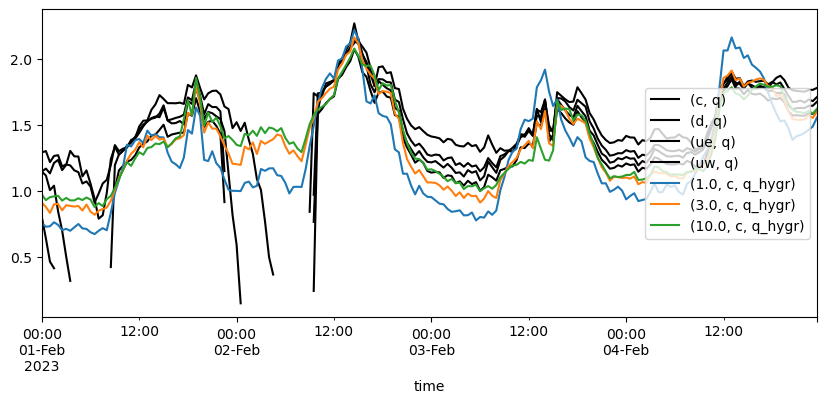

In [38]:
ax = abs_hum_field_df[3].loc['20230201': '20230204'].plot(figsize=(10,4), color='black', legend=False)
(1000*abs_hum_field_hygr_df.loc['20230201': '20230204']).plot(figsize=(10,4), ax=ax)
plt.legend(loc='right')

# 3D Differential Solution

## Calculate interpolated fields (3D)

In [ ]:
HEIGHTS = [3,10]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df = df[HEIGHTS]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_repeated = xxx.loc[xxx.index.repeat(len(data_df))]
instrument_loc_limited_heights_repeated.index = data_df.index
instrument_loc_limited_heights_repeated
data_df = data_df.join(instrument_loc_limited_heights_repeated)

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx, yy, zz = np.meshgrid(
    np.linspace(instrument_loc_limited_heights.x.min(), instrument_loc_limited_heights.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights.y.min(), instrument_loc_limited_heights.y.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights.z.min(), instrument_loc_limited_heights.z.max(), VERT_GRID_SPACING)
)
spacing_x = np.diff(xx[0,:,0]).mean()
spacing_y = np.diff(yy[:,0,0]).mean()
spacing_z = np.diff(zz[0,0,:]).mean()
points = np.transpose(np.vstack((instrument_loc_limited_heights.x, instrument_loc_limited_heights.y, instrument_loc_limited_heights.z)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp = data_df.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
v_interp = data_df.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
w_interp = data_df.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp = data_df.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
v_q__interp = data_df.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
w_q__interp = data_df.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp = data_df.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
r_interp = data_df.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
q_interp = data_df.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)

### PLOT: Example of a 3d interpolated wind field

In [ ]:

ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.quiver(
    xx[::5,::5,::2], 
    yy[::5,::5,::2],
    zz[::5,::5,::2],
    u_interp[100][::5,::5,::2],
    v_interp[100][::5,::5,::2], 
    w_interp[100][::5,::5,::2],
    label='interpolated'
)
# plt.quiver(
#     data_df.iloc[100][(slice(None),slice(None),'x')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'y')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'z')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'u')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'v')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'w')].values.astype('float'),
#     label='measured',
#     color='red'
# )

In [ ]:
stable_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_stable_times)].values), axis = 0)
stable_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_stable_times)].values), axis = 0)
stable_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_stable_times)].values), axis = 0)
# 3d plot
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.quiver(xx[::5,::5,::2],     yy[::5,::5,::2],    zz[::5,::5,::2], stable_mean_u_field[::5,::5,::2], stable_mean_v_field[::5,::5,::2],  stable_mean_w_field[::5,::5,::2],label='interpolated',)

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(5,7.5), sharex=True, sharey=True)
for ax in axes.flatten():
    ax.set_aspect('equal')

stable_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_stable_times)].values), axis = 0)
stable_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_stable_times)].values), axis = 0)
stable_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_stable_times)].values), axis = 0)
axes[0,0].quiver(
    xx[::5,::5,4],  yy[::5,::5,4],
    stable_mean_u_field[::5,::5,4], stable_mean_v_field[::5,::5,4], 
)
axes[0,0].set_title('stable, 4.5m')
axes[0,1].quiver(
    xx[::5,::5,15],  yy[::5,::5,15],
    stable_mean_u_field[::5,::5,15], stable_mean_v_field[::5,::5,15], 
)
axes[0,1].set_title('stable, 8m')

unstable_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_unstable_times)].values), axis = 0)
unstable_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_unstable_times)].values), axis = 0)
unstable_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_unstable_times)].values), axis = 0)
axes[1,0].quiver(
    xx[::5,::5,4],  yy[::5,::5,4],
    unstable_mean_u_field[::5,::5,4], unstable_mean_v_field[::5,::5,4], 
)
axes[1,0].set_title('unstable, 4.5m')
axes[1,1].quiver(
    xx[::5,::5,15],  yy[::5,::5,15],
    unstable_mean_u_field[::5,::5,15], unstable_mean_v_field[::5,::5,15], 
)
axes[1,1].set_title('unstable, 8m')

neutral_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_neutral_times)].values), axis = 0)
neutral_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_neutral_times)].values), axis = 0)
neutral_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_neutral_times)].values), axis = 0)
axes[2,0].quiver(
    xx[::5,::5,4],  yy[::5,::5,4],
    neutral_mean_u_field[::5,::5,4], neutral_mean_v_field[::5,::5,4], 
)
axes[2,0].set_title('neutral, 4.5m')
axes[2,1].quiver(
    xx[::5,::5,15],  yy[::5,::5,15],
    neutral_mean_u_field[::5,::5,15], neutral_mean_v_field[::5,::5,15], 
)
axes[2,1].set_title('neutral, 8m')
plt.tight_layout()

In [ ]:
src_unstable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_unstable = src_unstable[(src_unstable.time >= '20221130') & (src_unstable.time < '20230509')]
src_unstable = src_unstable[src_unstable.time.isin(set(ri_unstable_times).intersection(set(nobs_times)))]
src_unstable = src_unstable.pivot_table(index='time', values='value', columns='variable')
src_unstable['diff_unstable'] = src_unstable['w_h2o__20m_c'] - src_unstable['w_h2o__3m_c']

src_stable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_stable = src_stable[(src_stable.time >= '20221130') & (src_stable.time < '20230509')]
src_stable = src_stable[src_stable.time.isin(set(ri_stable_times).intersection(set(nobs_times)))]
src_stable = src_stable.pivot_table(index='time', values='value', columns='variable')
src_stable['diff_stable'] = src_stable['w_h2o__20m_c'] - src_stable['w_h2o__3m_c']

src_neutral = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_neutral = src_neutral[(src_neutral.time >= '20221130') & (src_neutral.time < '20230509')]
src_neutral = src_neutral[src_neutral.time.isin(set(ri_neutral_times).intersection(set(nobs_times)))]
src_neutral = src_neutral.pivot_table(index='time', values='value', columns='variable')
src_neutral['diff_neutral'] = src_neutral['w_h2o__20m_c'] - src_neutral['w_h2o__3m_c']

src = pd.concat([
    src_neutral[['diff_neutral']].reset_index(),
    src_stable[['diff_stable']].reset_index(),
    src_unstable[['diff_unstable']].reset_index(),
])
alt.Chart(
    src.reset_index()
    # src.reset_index()
).transform_fold([
    'diff_neutral', 'diff_stable', 'diff_unstable'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=150, height=150)

In [ ]:
src_unstable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_unstable = src_unstable[(src_unstable.time >= '20221130') & (src_unstable.time < '20230509')]
src_unstable = src_unstable[src_unstable.time.isin(set(ri_unstable_times).intersection(set(nobs_times)))]
src_unstable = src_unstable.pivot_table(index='time', values='value', columns='variable')
src_unstable = src_unstable.reset_index()

src_stable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_stable = src_stable[(src_stable.time >= '20221130') & (src_stable.time < '20230509')]
src_stable = src_stable[src_stable.time.isin(set(ri_stable_times).intersection(set(nobs_times)))]
src_stable = src_stable.pivot_table(index='time', values='value', columns='variable')
src_stable = src_stable.reset_index()

src_neutral = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_neutral = src_neutral[(src_neutral.time >= '20221130') & (src_neutral.time < '20230509')]
src_neutral = src_neutral[src_neutral.time.isin(set(ri_neutral_times).intersection(set(nobs_times)))]
src_neutral = src_neutral.pivot_table(index='time', values='value', columns='variable')
src_neutral = src_neutral.reset_index()

chart = alt.Chart(
).transform_fold([
    'w_h2o__3m_c', 'w_h2o__20m_c'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
)

alt.layer(
    chart,
    data =  src_stable[(src_stable.time >= '20221130') & (src_stable.time < '20230509')].reset_index()
) | alt.layer(
    chart,
    data =  src_neutral[(src_neutral.time >= '20221130') & (src_neutral.time < '20230509')].reset_index()
) | alt.layer(
    chart,
    data =  src_unstable[(src_unstable.time >= '20221130') & (src_unstable.time < '20230509')].reset_index()
)



In [ ]:
src_unstable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_unstable = src_unstable[src_unstable.time.isin(set(ri_unstable_times).intersection(set(nobs_times)))]
src_unstable = src_unstable.pivot_table(index='time', values='value', columns='variable')
src_unstable['diff_unstable'] = src_unstable['w_h2o__20m_c'] - src_unstable['w_h2o__3m_c']

src_stable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_stable = src_stable[src_stable.time.isin(set(ri_stable_times).intersection(set(nobs_times)))]
src_stable = src_stable.pivot_table(index='time', values='value', columns='variable')
src_stable['diff_stable'] = src_stable['w_h2o__20m_c'] - src_stable['w_h2o__3m_c']

src_neutral = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_neutral = src_neutral[src_neutral.time.isin(set(ri_neutral_times).intersection(set(nobs_times)))]
src_neutral = src_neutral.pivot_table(index='time', values='value', columns='variable')
src_neutral['diff_neutral'] = src_neutral['w_h2o__20m_c'] - src_neutral['w_h2o__3m_c']

src = pd.concat([
    src_neutral[['diff_neutral']].reset_index(),
    src_stable[['diff_stable']].reset_index(),
    src_unstable[['diff_unstable']].reset_index(),
])
alt.Chart(
    src[(src.time >= '20221130') & (src.time < '20230509')].reset_index()
    # src.reset_index()
).transform_fold([
    'diff_neutral', 'diff_stable', 'diff_unstable'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
)

In [ ]:
src = tidy_df.query("measurement == 'wind direction'")
src = src[src.time.isin(ri_unstable_times)]
src
alt.Chart(src).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.Facet('tower:N')
)

## Calculate terms (3D)

Calculate advective terms in both the Paw U form

$u \rho \dfrac{\partial s}{\partial x} + v \rho \dfrac{\partial s}{\partial y} + w \rho \dfrac{\partial s}{\partial z}$

and in the Sun form

$u \dfrac{\partial q}{\partial x} + v \dfrac{\partial q}{\partial y} + w \dfrac{\partial q}{\partial z}$

and also calculate the turbulent flux divergence terms (same for Paw U and Sun)

$\dfrac{\partial \overline{u'q'}}{\partial x} + \dfrac{\partial \overline{v'q'}}{\partial y} + \dfrac{\partial \overline{w'q'}}{\partial z}$

In [ ]:
# Create dataframe with grids of interpolated data
u_interp.name = 'u'
v_interp.name = 'v'
w_interp.name = 'w'
u_q__interp.name = 'u_q_'
v_q__interp.name = 'v_q_'
w_q__interp.name = 'w_q_'
rho_interp.name = 'rho'
r_interp.name = 'r'
q_interp.name = 'q'

fields_df = pd.DataFrame(u_interp).join(
    v_interp
).join(
    w_interp
).join(
    u_q__interp
).join(
    v_q__interp
).join(
    w_q__interp
).join(
    rho_interp
).join(
    r_interp
).join(
    q_interp
)

In [ ]:
# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
# means of:  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
# medians of:  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_3d = fields_df.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y, axis=1)
        ),
        # Vertical advection Paw U style
        np.nanmean(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y, axis=1)
        ),
        # Vertical advection Sun style
        np.nanmean(row['w']*np.gradient(row['q'], spacing_z, axis=2)),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y, axis=1)
        ),
        # Vertical turb. flux divergence
        np.nanmean(np.gradient(row['w_q_'], spacing_z, axis=2)),
        # Vertical air density flux term (Paw U only)
        ###???
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y, axis=1)
        ),
        # Vertical advection Paw U style
        np.nanmedian(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y, axis=1)
        ),
        # Vertical advection Sun style
        np.nanmedian(row['w']*np.gradient(row['q'], spacing_z, axis=2)),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y, axis=1)
        ),
        # Vertical turb. flux divergence
        np.nanmedian(np.gradient(row['w_q_'], spacing_z, axis=2)),
        # Vertical air density flux term (Paw U only)
        ###???
    )
    ,
    axis = 1
)
advective_terms_3d = pd.DataFrame(
    [[a, b, c, d, e, f, g, h, i, j, k, l] for a,b,c,d,e,f,g,h,i,j,k,l in advective_terms_3d.values], 
    columns=[
        'lateral_advection_pawu (mean)',
        'vertical_advection_pawu (mean)',
        'lateral_advection_sun (mean)',
        'vertical_advection_sun (mean)',
        'lateral_turb_flux_div (mean)',
        'vertical_turb_flux_div (mean)',
        
        'lateral_advection_pawu (median)',
        'vertical_advection_pawu (median)',
        'lateral_advection_sun (median)',
        'vertical_advection_sun (median)',
        'lateral_turb_flux_div (median)',
        'vertical_turb_flux_div (median)',
    ]
)
advective_terms_3d.index = fields_df.index

In [ ]:
advective_terms_3d = advective_terms_3d*7
advective_terms_3d

## Calculate vertical velocity from horizontal divergence.

Following Vickers and Mahrt (2006), for incompressible mass continuity, time averaged vertical velocity based on divergence in 

$$ w(h) = - \int_{z=0}^{z=h} (\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}) dz$$

In [ ]:
def get_w_for_row(row):
    data = - np.nansum(
        (
            np.gradient(row['u'], spacing_x, axis=0)
            + np.gradient(row['v'], spacing_y, axis=1)
        ),
        axis = 2
    ) * (
        instrument_loc_limited_heights.z.max() 
        - instrument_loc_limited_heights.z.min()
    )

    data[data == 0] = np.nan
    data
    return np.nanmedian(data)

w_from_div = fields_df.apply(get_w_for_row, axis = 1)

alt.Chart(pd.DataFrame(w_from_div.rename('w')).reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(w):Q')
)

## Examine results

In [ ]:
mean_chart = (alt.Chart(
    (advective_terms_3d/7).reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c and 'mean' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c and 'mean' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)).resolve_scale(color='independent')

median_chart = (alt.Chart(
    (advective_terms_3d/7).reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c and 'median' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c and 'median' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)).resolve_scale(color='independent')

(mean_chart & median_chart).resolve_scale(y='shared', x='shared')

In [ ]:
alt.Chart(
    advective_terms_3d.loc['20230201': '20230205'].reset_index()
).transform_fold(
    list(advective_terms_3d.columns)
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    # .scale(domain=[0,0.02], clamp=True),
    alt.Color('key:N')
)

# 2D Differential Solution

## 3m height

Repeat all the steps we did above, but just for a single plane at 3m

In [ ]:
HEIGHTS_2D = [3]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df_2d = df[HEIGHTS_2D]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights_2d = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS_2D)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights_2d.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_2d_repeated = xxx.loc[xxx.index.repeat(len(data_df_2d))]
instrument_loc_limited_heights_2d_repeated.index = data_df_2d.index
instrument_loc_limited_heights_2d_repeated
data_df_2d = data_df_2d.join(instrument_loc_limited_heights_2d_repeated)
data_df_2d

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx_2d, yy_2d = np.meshgrid(
    np.linspace(instrument_loc_limited_heights_2d.x.min(), instrument_loc_limited_heights_2d.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights_2d.y.min(), instrument_loc_limited_heights_2d.y.max(), HORIZ_GRID_SPACING)
)
spacing_x_2d = np.diff(xx_2d[0,:]).mean()
spacing_y_2d = np.diff(yy_2d[:,0]).mean()
points_2d = np.transpose(np.vstack((instrument_loc_limited_heights_2d.x, instrument_loc_limited_heights_2d.y)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
r_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
q_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)

# Create dataframe with grids of interpolated data
u_interp_2d.name = 'u'
v_interp_2d.name = 'v'
w_interp_2d.name = 'w'
u_q__interp_2d.name = 'u_q_'
v_q__interp_2d.name = 'v_q_'
w_q__interp_2d.name = 'w_q_'
rho_interp_2d.name = 'rho'
r_interp_2d.name = 'r'
q_interp_2d.name = 'q'

fields_df_2d = pd.DataFrame(u_interp_2d).join(
    v_interp_2d
).join(
    w_interp_2d
).join(
    u_q__interp_2d
).join(
    v_q__interp_2d
).join(
    w_q__interp_2d
).join(
    rho_interp_2d
).join(
    r_interp_2d
).join(
    q_interp_2d
)

# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
#  means of: lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
#  medians of: lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_2d_3m = fields_df_2d.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
    ),
    axis = 1
)
advective_terms_2d_3m = pd.DataFrame(
    [[a, b, c, d, e, f] for a, b, c, d, e, f in advective_terms_2d_3m.values], 
    columns=[
        'lateral_advection_pawu (mean)', 
        'lateral_advection_sun (mean)',
        'lateral_turb_flux_div (mean)', 
        'lateral_advection_pawu (median)', 
        'lateral_advection_sun (median)',
        'lateral_turb_flux_div (median)', 
    ]
)
advective_terms_2d_3m.index = fields_df_2d.index

### PLOT: Example of a 2d interpolated wind field

In [ ]:

plt.quiver(
    xx_2d[::4], 
    yy_2d[::4],
    u_interp_2d[100][::4],
    v_interp_2d[100][::4], 
    label='interpolated'
)
plt.quiver(
    data_df_2d.iloc[100][(slice(None),slice(None),'x')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'y')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'u')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'v')].values.astype('float'),
    label='measured',
    color='red'
)

## 10m height

Repeat all the steps we did above, but just for a single plane at 3m

In [ ]:
HEIGHTS_2D = [10]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df_2d = df[HEIGHTS_2D]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights_2d = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS_2D)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights_2d.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_2d_repeated = xxx.loc[xxx.index.repeat(len(data_df_2d))]
instrument_loc_limited_heights_2d_repeated.index = data_df_2d.index
instrument_loc_limited_heights_2d_repeated
data_df_2d = data_df_2d.join(instrument_loc_limited_heights_2d_repeated)
data_df_2d

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx_2d, yy_2d = np.meshgrid(
    np.linspace(instrument_loc_limited_heights_2d.x.min(), instrument_loc_limited_heights_2d.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights_2d.y.min(), instrument_loc_limited_heights_2d.y.max(), HORIZ_GRID_SPACING)
)
spacing_x_2d = np.diff(xx_2d[0,:]).mean()
spacing_y_2d = np.diff(yy_2d[:,0]).mean()
points_2d = np.transpose(np.vstack((instrument_loc_limited_heights_2d.x, instrument_loc_limited_heights_2d.y)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
r_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
q_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)

# Create dataframe with grids of interpolated data
u_interp_2d.name = 'u'
v_interp_2d.name = 'v'
w_interp_2d.name = 'w'
u_q__interp_2d.name = 'u_q_'
v_q__interp_2d.name = 'v_q_'
w_q__interp_2d.name = 'w_q_'
rho_interp_2d.name = 'rho'
r_interp_2d.name = 'r'
q_interp_2d.name = 'q'

fields_df_2d = pd.DataFrame(u_interp_2d).join(
    v_interp_2d
).join(
    w_interp_2d
).join(
    u_q__interp_2d
).join(
    v_q__interp_2d
).join(
    w_q__interp_2d
).join(
    rho_interp_2d
).join(
    r_interp_2d
).join(
    q_interp_2d
)

# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
#  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_2d_10m = fields_df_2d.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
    ),
    axis = 1
)
advective_terms_2d_10m = pd.DataFrame(
    [[a, b, c, d, e, f] for a, b, c, d, e, f in advective_terms_2d_10m.values], 
    columns=[
        'lateral_advection_pawu (mean)', 
        'lateral_advection_sun (mean)',
        'lateral_turb_flux_div (mean)', 
        'lateral_advection_pawu (median)', 
        'lateral_advection_sun (median)',
        'lateral_turb_flux_div (median)', 
    ]
)
advective_terms_2d_10m.index = fields_df_2d.index

## Average the two planes

In [ ]:
advective_terms_2d_3m

In [ ]:
advective_terms_2d_10m

In [ ]:
advective_terms_2d = (advective_terms_2d_3m + advective_terms_2d_10m)/2
advective_terms_2d = advective_terms_2d*7

## Examine results

In [ ]:
alt.Chart(
    advective_terms_2d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_2d.columns) if 'turb' not in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_2d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_2d.columns) if 'turb' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)

In [ ]:
alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)

# Surface Integral Solution

## Define area of triangular prism faces

In [ ]:
# Define face areas
A1 = A2 = A3 = 37 * 7 * units('m^2')
A4 = A5 = 580.2 * units('m^2')
CV_HEIGHT = 7*units('m')
VOLUME = A4*CV_HEIGHT
A1, A2, A3, A4, A5, VOLUME

## Define normal vectors to the triangular prism faces

In [ ]:
# ELI'S angles
n1 = np.array([ np.cos(np.deg2rad(258.7)),   np.sin(np.deg2rad(258.7))])*units(None)
n2 = np.array([ np.cos(np.deg2rad(20.1)),   np.sin(np.deg2rad(20.1))])*units(None)
n3 = np.array([ np.cos(np.deg2rad(139.26)),   np.sin(np.deg2rad(139.26))])*units(None)

# DANNY'S angles
# n1 = np.array([ np.cos(np.deg2rad(269.5)),   np.sin(np.deg2rad(269.5))])*units(None)
# n2 = np.array([ np.cos(np.deg2rad(19.5)),   np.sin(np.deg2rad(19.5))])*units(None)
# n3 = np.array([ np.cos(np.deg2rad(143.5)),   np.sin(np.deg2rad(143.5))])*units(None)

In [ ]:

instrument_loc_df = gpd.GeoDataFrame(
    instrument_loc_df,
    geometry = gpd.points_from_xy(
        instrument_loc_df.x, 
        instrument_loc_df.y, 
        instrument_loc_df.z
    ),
    crs = 'EPSG:32613'
)
instrument_loc_df = instrument_loc_df.to_crs('EPSG:4326')
instrument_loc_df

## Calculate storage term

In [ ]:
storage_change_term = tidy_df[
    tidy_df.measurement.isin(['specific humidity', 'air density'])
].query("tower == 'c'").query("height <= 10").query("height >= 3").groupby(
    ['time', 'tower', 'measurement']
)[['value']].mean().reset_index() 
storage_change_term = storage_change_term.pivot_table(index='time', values='value', columns='measurement')

In [ ]:
timestep = storage_change_term.index.diff()[1].seconds * units('seconds')
print(timestep)
absolute_humidity = storage_change_term['specific humidity'].values * units("g/g")  * (
    storage_change_term['air density'].values * units("kg/m^3")
)
delta_humidity = np.diff(absolute_humidity * VOLUME, prepend=np.nan)
dq_dt = delta_humidity / timestep

In [ ]:
storage_change_term['absolute humidity (g/m^3)'] = absolute_humidity.to('g/m^3')
storage_change_term['delta water storage (g/s)'] = dq_dt.to('grams/second')

## Calculate advective flux

In [ ]:
advective_flux_3m_ue = wind_field_df[3]['ue'].multiply(
    abs_hum_field_df[3]['ue']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_ue = wind_field_df[10]['ue'].multiply(
    abs_hum_field_df[10]['ue']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_uw = wind_field_df[3]['uw'].multiply(
    abs_hum_field_df[3]['uw']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_uw = wind_field_df[10]['uw'].multiply(
    abs_hum_field_df[10]['uw']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_d = wind_field_df[3]['d'].multiply(
    abs_hum_field_df[3]['d']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_d = wind_field_df[10]['d'].multiply(
    abs_hum_field_df[10]['d']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_c = wind_field_df[3]['c'].multiply(
    abs_hum_field_df[3]['c']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_c = wind_field_df[10]['c'].multiply(
    abs_hum_field_df[10]['c']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

In [ ]:
# Calculate the average u, v, and w components needed to calculate flux through each face
face1_avg_u_flux = 0.25*(
    advective_flux_3m_uw['uq'] + advective_flux_10m_uw['uq'] + 
    advective_flux_3m_d['uq'] + advective_flux_10m_d['uq']
)

face1_avg_v_flux = 0.25*(
    advective_flux_3m_uw['vq'] + advective_flux_10m_uw['vq'] + 
    advective_flux_3m_d['vq'] + advective_flux_10m_d['vq']
)

face2_avg_u_flux = 0.25*(
    advective_flux_3m_ue['uq'] + advective_flux_10m_ue['uq'] + 
    advective_flux_3m_d['uq'] + advective_flux_10m_d['uq']
)

face2_avg_v_flux = 0.25*(
    advective_flux_3m_ue['vq'] + advective_flux_10m_ue['vq'] + 
    advective_flux_3m_d['vq'] + advective_flux_10m_d['vq']
)

face3_avg_u_flux = 0.25*(
    advective_flux_3m_ue['uq'] + advective_flux_10m_ue['uq'] + 
    advective_flux_3m_uw['uq'] + advective_flux_10m_uw['uq']
)

face3_avg_v_flux = 0.25*(
    advective_flux_3m_ue['vq'] + advective_flux_10m_ue['vq'] + 
    advective_flux_3m_uw['vq'] + advective_flux_10m_uw['vq']
)

face4_avg_w_flux = 0.25*(
    advective_flux_10m_ue['wq'] + advective_flux_10m_uw['wq'] + 
    advective_flux_10m_c['wq'] + advective_flux_10m_d['wq']
)

face5_avg_w_flux = - 0.25*(
    advective_flux_3m_ue['wq'] + advective_flux_3m_uw['wq'] + 
    advective_flux_3m_c['wq'] + advective_flux_3m_d['wq']
)

# Combine the (separate) u and v components into a list of vectors for the lateral faces
face1_avg_adv_flux = np.array([
    face1_avg_u_flux,
    face1_avg_v_flux
]).T

face2_avg_adv_flux = np.array([
    face2_avg_u_flux,
    face2_avg_v_flux
]).T

face3_avg_adv_flux = np.array([
    face3_avg_u_flux,
    face3_avg_v_flux
]).T

# Project the lateral flux vectors onto the face-normal vectors
face1_projected_adv_flux = np.dot(face1_avg_adv_flux, n1.m)
face2_projected_adv_flux = np.dot(face2_avg_adv_flux, n2.m)
face3_projected_adv_flux = np.dot(face3_avg_adv_flux, n3.m)

# Calculate total lateral and vertical flux
total_lateral_adv_divergence = (
    face1_projected_adv_flux*A1.m + 
    face2_projected_adv_flux*A2.m + 
    face3_projected_adv_flux*A3.m
) / VOLUME.m

total_vertical_adv_divergence = (face4_avg_w_flux*A4 + face5_avg_w_flux*A5)  / VOLUME

## Calculate turbulent flux divergence

In [ ]:
# Calculate the average u, v, and w components needed to calculate flux through each face
face1_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['uw']['u_h2o_'] + turb_flux_field_df[10]['uw']['u_h2o_'] + 
    turb_flux_field_df[3]['d']['u_h2o_'] + turb_flux_field_df[10]['d']['u_h2o_']
)

face1_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['uw']['v_h2o_'] + turb_flux_field_df[10]['uw']['v_h2o_'] + 
    turb_flux_field_df[3]['d']['v_h2o_'] + turb_flux_field_df[10]['d']['v_h2o_']
)

face2_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['u_h2o_'] + turb_flux_field_df[10]['ue']['u_h2o_'] + 
    turb_flux_field_df[3]['d']['u_h2o_'] + turb_flux_field_df[10]['d']['u_h2o_']
)

face2_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['v_h2o_'] + turb_flux_field_df[10]['ue']['v_h2o_'] + 
    turb_flux_field_df[3]['d']['v_h2o_'] + turb_flux_field_df[10]['d']['v_h2o_']
)

face3_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['u_h2o_'] + turb_flux_field_df[10]['ue']['u_h2o_'] + 
    turb_flux_field_df[3]['uw']['u_h2o_'] + turb_flux_field_df[10]['uw']['u_h2o_']
)

face3_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['v_h2o_'] + turb_flux_field_df[10]['ue']['v_h2o_'] + 
    turb_flux_field_df[3]['uw']['v_h2o_'] + turb_flux_field_df[10]['uw']['v_h2o_']
)

face4_avg_w_turb_flux = 0.25*(
    turb_flux_field_df[10]['ue']['w_h2o_'] + turb_flux_field_df[10]['uw']['w_h2o_'] + 
    turb_flux_field_df[10]['c']['w_h2o_'] + turb_flux_field_df[10]['d']['w_h2o_']
)

face5_avg_w_turb_flux = - 0.25*(
    turb_flux_field_df[3]['ue']['w_h2o_'] + turb_flux_field_df[3]['uw']['w_h2o_'] + 
    turb_flux_field_df[3]['c']['w_h2o_'] + turb_flux_field_df[3]['d']['w_h2o_']
)

# Combine the (separate) u and v components into a list of vectors for the lateral faces
face1_avg_adv_flux = np.array([
    face1_avg_u_turb_flux,
    face1_avg_v_turb_flux
]).T

face2_avg_adv_flux = np.array([
    face2_avg_u_turb_flux,
    face2_avg_v_turb_flux
]).T

face3_avg_adv_flux = np.array([
    face3_avg_u_turb_flux,
    face3_avg_v_turb_flux
]).T

# Project the lateral flux vectors onto the face-normal vectors
face1_projected_turb_flux = np.dot(face1_avg_adv_flux, n1.m)
face2_projected_turb_flux = np.dot(face2_avg_adv_flux, n2.m)
face3_projected_turb_flux = np.dot(face3_avg_adv_flux, n3.m)

# Calculate total lateral and vertical flux
total_lateral_turb_divergence = (
    face1_projected_turb_flux*A1.m + 
    face2_projected_turb_flux*A2.m + 
    face3_projected_turb_flux*A3.m
) / VOLUME.m

total_vertical_turb_divergence = (face4_avg_w_turb_flux*A4 + face5_avg_w_turb_flux*A5)  / VOLUME

## Examine results

In [ ]:
((
    alt.Chart(
        pd.DataFrame(total_vertical_turb_divergence).reset_index()
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(w_h2o_):Q')
    )
).properties(title='Vertical Turb. Flux Divergence') | (
    alt.Chart(
        pd.DataFrame(total_lateral_turb_divergence).reset_index().assign(time=total_vertical_turb_divergence.index).rename(columns={0:'u_q_'})
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(u_q_):Q')
    )
).properties(title='Lateral Turb. Flux Divergence')).resolve_scale(y='shared', x='shared')

In [ ]:
((
    alt.Chart(
        pd.DataFrame(total_vertical_adv_divergence).reset_index()
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(wq):Q')
    )
    +
    alt.Chart(
        pd.DataFrame(total_vertical_adv_divergence).reset_index()
    ).mark_line(color='red').encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(wq):Q')
    )
).properties(title='Vertical Advection') | (
    alt.Chart(
        pd.DataFrame(total_lateral_adv_divergence).reset_index().assign(time=total_vertical_adv_divergence.index).rename(columns={0:'uq'})
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(uq):Q')
    )
    +
    alt.Chart(
        pd.DataFrame(total_lateral_adv_divergence).reset_index().assign(time=total_vertical_adv_divergence.index).rename(columns={0:'uq'})
    ).mark_line(color='red').encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(uq):Q')
    )
).properties(title='Lateral Advection')).resolve_scale(y='shared', x='shared')

# 1D Differential Solution

## Look at relative snow depths

In [39]:
kps_snowdepth_df = tidy_df.query("variable == 'SnowDepth_c'").set_index('time')
annex_snowdepth_df = annex_snowdepth_ds.to_dataframe()#.loc[kps_snowdepth_df.index.min(), kps_snowdepth_df.index.max()]
annex_snowdepth_df = annex_snowdepth_df.resample('30min').median().loc[kps_snowdepth_df.index.min(): kps_snowdepth_df.index.max()]

In [40]:
kps_src = (tidy_df.query(
        "measurement == 'mixing ratio'"
    ).set_index('time').loc['20230201 1000': '20230201 1500'].query(
        "height > 0"
    )).reset_index()
kps_src['value'] = kps_src['value'] * 1000
alt.Chart(
    kps_src.query("height <= 5")
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=False),
    alt.Color('height:O')
) +\
alt.Chart(
mixingratio_ds.to_dataframe().sort_index().loc['20230201 1000': '20230201 1500'].resample('30min').mean().reset_index()
).mark_line(color='red').encode(
    alt.X('time:T'),
    alt.Y('mixing_ratio:Q').scale(zero=False)
)

alt.LayerChart(...)

In [41]:
snowdepth_pair = pd.DataFrame(annex_snowdepth_df['snow_depth'].rename('annex')).join(
    (100*kps_snowdepth_df['value'].rename('kps'))
).reset_index()

onetoone_line = alt.Chart(pd.DataFrame({'x':[0, 200], 'y':[0, 200]})).mark_line(color='grey').encode(x='x', y='y')
(alt.Chart(snowdepth_pair).mark_line().transform_fold([
    'annex', 'kps'
]).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('key:N')
) | onetoone_line+alt.Chart(snowdepth_pair.set_index('time').resample('1440min').mean().reset_index()).mark_circle().encode(
    alt.X('annex:Q'),
    alt.Y('kps:Q')
)).configure_legend(orient='top')

alt.HConcatChart(...)

## Calculate air density flux term

In [42]:
airdensityflux_df = tidy_df[tidy_df.variable.isin([
    'dryairdensity_3m_c',   'dryairdensity_20m_c',
    'T_3m_c',   'T_20m_c',
    'mixingratio_3m_c',   'mixingratio_20m_c',
    'w_tc__3m_c',   'w_tc__20m_c',
    'w_h2o__3m_c',   'w_h2o__20m_c',
])].pivot(index='time', columns='variable', values='value')

mean_mixing_ratio = tidy_df.query(
    "measurement == 'mixing ratio'"
).query(
    "height >= 3"
).query(
    "height <= 20"
).groupby('time').value.mean().rename('mixingratio_mean_3to17')

airdensityflux_df = airdensityflux_df.join(mean_mixing_ratio)

# ALL KELVIN
UNITS_FOR_T_MEAS = units('kelvin')
UNITS_FOR_SH_FLUX = units("kelvin*m/s")
airdensityflux_df['T_3m_c'] = (airdensityflux_df['T_3m_c'].values * units("degC")).to(UNITS_FOR_T_MEAS)
airdensityflux_df['T_20m_c'] = (airdensityflux_df['T_20m_c'].values * units("degC")).to(UNITS_FOR_T_MEAS)

# ALL CELSIUS
# UNITS_FOR_T_MEAS = units('degC')
# UNITS_FOR_SH_FLUX = units("degC*m/s")
# airdensityflux_df['T_3m_c'] = (airdensityflux_df['T_3m_c'].values * units("degC")).to(UNITS_FOR_T_MEAS)
# airdensityflux_df['T_20m_c'] = (airdensityflux_df['T_20m_c'].values * units("degC")).to(UNITS_FOR_T_MEAS)

mu = 1/0.622
air_density_flux = (
    (
        airdensityflux_df['mixingratio_mean_3to17'].values * units("g/g")
    ) * (
        (
            ((airdensityflux_df['dryairdensity_20m_c'].values * units("kg/m^3")) / (airdensityflux_df['T_20m_c'].values * UNITS_FOR_T_MEAS))
            * (1 + mu * (airdensityflux_df['mixingratio_20m_c'].values * units("g/g")))
            * (airdensityflux_df['w_tc__20m_c'].values * UNITS_FOR_SH_FLUX) + mu*(airdensityflux_df['w_h2o__20m_c'].values * units("g/m^2/s"))
        )
        -
        (
            ((airdensityflux_df['dryairdensity_3m_c'].values * units("kg/m^3")) / (airdensityflux_df['T_3m_c'].values * UNITS_FOR_T_MEAS))
            * (1 + mu * (airdensityflux_df['mixingratio_3m_c'].values * units("g/g")))
            * (airdensityflux_df['w_tc__3m_c'].values * UNITS_FOR_SH_FLUX) + mu*(airdensityflux_df['w_h2o__3m_c'].values * units("g/m^2/s"))
        )

    ) / (17 * units('m'))
).to(units('g/m^3/s'))

airdensityflux_df['air_density_flux'] = air_density_flux
air_density_flux

Magnitude,[1.2295649254856986e-05 -6.232258178487104e-06 4.353745703954638e-06 ... 4.982537419223445e-06 0.00010208332318970368 -9.113231327394653e-05]
Units,gram/(meter3 second)


## Calculate horizontal advection and storage change term (using two-point solution to derivative)

In [43]:

# combine mixing ratio measurements from the two sites into one dataframe 
kpsannex_mixingratio_measurements = mixingratio_ds.sortby('time').sel(
    time=slice(data_start_date, data_cutoff_date)
).resample(time='30min').mean().rename('annex').to_dataframe() / 1000
# kps_mixingratio_measurements = abs_hum_field_hygr_df[3]['c']['q_hygr'].rename('kps')
kps_mixingratio_measurements_2m = tidy_df.query("variable == 'mixingratio_2m_c'").set_index('time')['value'].rename('kps_2m')
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time')['value'].rename('kps_3m')
kps_mixingratio_measurements_4m = tidy_df.query("variable == 'mixingratio_4m_c'").set_index('time')['value'].rename('kps_4m')

kps_lateral_simple_df = kpsannex_mixingratio_measurements.join(
    kps_mixingratio_measurements_2m
).join(
    kps_mixingratio_measurements_3m
).join(
    kps_mixingratio_measurements_4m
)

# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_lateral_simple_df = kps_lateral_simple_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time')['value'].rename('dir_10m_c')
).join(
    tidy_df.query("variable == 'spd_3m_c'").set_index('time')['value'].rename('spd_3m_c')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time')['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].rename('w_h2o__3m_c')
)

kps_lateral_simple_df = kps_lateral_simple_df[
    ((kps_lateral_simple_df.dir_10m_c >= 112) & (kps_lateral_simple_df.dir_10m_c <= 152))
    |
    ((kps_lateral_simple_df.dir_10m_c >= 292) & (kps_lateral_simple_df.dir_10m_c <= 332))
]
# label each timestamp up or downvalley
kps_lateral_simple_df['direction'] = kps_lateral_simple_df['dir_10m_c'].apply(lambda x: 'down' if 292 <= x <= 332 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_lateral_simple_df['ds_2m'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps_2m'] if row['direction'] == 'down' else row['kps_2m'] - row['annex'],
    axis=1
)
kps_lateral_simple_df['ds_3m'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps_3m'] if row['direction'] == 'down' else row['kps_3m'] - row['annex'],
    axis=1
)

kps_lateral_simple_df['ds_3m_uncertainty'] = 0.2/1000

kps_lateral_simple_df['ds_4m'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps_4m'] if row['direction'] == 'down' else row['kps_4m'] - row['annex'],
    axis=1
)
kps_lateral_simple_df['dx'] = 400
kps_lateral_simple_df['ds/dx 2m'] = kps_lateral_simple_df['ds_2m'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['ds/dx 3m'] = kps_lateral_simple_df['ds_3m'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['ds/dx 3m uncertainty'] = kps_lateral_simple_df['ds_3m_uncertainty'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['ds/dx 4m'] = kps_lateral_simple_df['ds_4m'] / kps_lateral_simple_df['dx']

kps_lateral_simple_df['lateral_advection_2m'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 2m']
kps_lateral_simple_df['lateral_advection_3m'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 3m']
kps_lateral_simple_df['lateral_advection_3m_uncertainty'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 3m uncertainty']
kps_lateral_simple_df['lateral_advection_4m'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 4m']


kps_lateral_simple_df['ds/dt'] = kps_lateral_simple_df['rho'] * (kps_lateral_simple_df[['kps_2m', 'kps_3m', 'kps_4m']].mean(axis=1)).diff() * units('g/g') / (30*60*units('seconds'))
# kps_lateral_simple_df

In [44]:
src = kps_lateral_simple_df[['lateral_advection_3m', 'lateral_advection_3m_uncertainty']]
src['ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']
src['lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']

alt.Chart(src.reset_index()).mark_area(opacity=0.5).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(lb):Q'),
    alt.Y2('mean(ub):Q')
) + alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(lateral_advection_3m):Q'),
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_90172/3574805051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_90172/3574805051.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']


alt.LayerChart(...)

### Using KPS Irga measurements

In [45]:
# get mixing ratio measurements from the corner towers
upwind_s = 0.5*(mixing_ratio_field_df[3, 'ue', 'r'] + mixing_ratio_field_df[3, 'uw', 'r'])
upwind_s.name = 'upwind_s'
kps_lateral_simple_irga_df = pd.DataFrame(upwind_s)
kps_lateral_simple_irga_df['downwind_s'] = mixing_ratio_field_df[3, 'd', 'r']


# # Add wind dir variable
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('dir_10m_c')
).join(
    tidy_df.query("variable == 'spd_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('spd_3m_c')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
)


# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df[
    ((kps_lateral_simple_irga_df.dir_10m_c >= 100) & (kps_lateral_simple_irga_df.dir_10m_c <= 140))
    |
    ((kps_lateral_simple_irga_df.dir_10m_c >= 300) & (kps_lateral_simple_irga_df.dir_10m_c <= 340))
]

# label each timestamp up or downvalley
kps_lateral_simple_irga_df['direction'] = kps_lateral_simple_irga_df['dir_10m_c'].apply(lambda x: 'down' if 300 <= x <= 340 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_lateral_simple_irga_df['ds'] = kps_lateral_simple_irga_df.apply(
    lambda row: row['downwind_s'] - row['upwind_s'] if row['direction'] == 'down' else row['upwind_s'] - row['downwind_s'],
    axis=1
)

kps_lateral_simple_irga_df['dx'] = 32
kps_lateral_simple_irga_df['ds/dx'] = kps_lateral_simple_irga_df['ds'] / kps_lateral_simple_irga_df['dx']

kps_lateral_simple_irga_df

kps_lateral_simple_irga_df['lateral_advection_irga'] = kps_lateral_simple_irga_df['spd_3m_c'] * kps_lateral_simple_irga_df['rho'] * kps_lateral_simple_irga_df['ds/dx']
kps_lateral_simple_irga_df

,upwind_s,downwind_s,dir_10m_c,spd_3m_c,rho,w_h2o__3m_c,direction,ds,dx,ds/dx,lateral_advection_irga
time,,,,,,,,,,,
2022-11-07 00:30:00,NaN,0.004077,134.259583,0.955278,925.138593,-0.000007,up,NaN,32,NaN,NaN
2022-11-07 01:00:00,NaN,0.004063,300.530640,1.061936,925.107300,-0.000472,down,NaN,32,NaN,NaN
2022-11-07 01:30:00,NaN,0.004051,326.844910,0.813213,925.180614,0.000190,down,NaN,32,NaN,NaN
2022-11-07 02:00:00,NaN,0.004053,103.661224,0.788725,922.916710,-0.000141,up,NaN,32,NaN,NaN
2022-11-07 02:30:00,NaN,0.003973,101.509117,0.726408,924.323022,-0.000117,up,NaN,32,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-18 20:00:00,0.004477,0.004596,134.443359,1.775853,870.331824,0.019672,up,-0.000119,32,-0.000004,-0.005752
2023-06-18 20:30:00,0.004588,0.004699,137.538605,1.760243,872.846305,0.015880,up,-0.000111,32,-0.000003,-0.005331
2023-06-18 21:30:00,0.005137,0.005193,136.888870,2.005440,883.653283,0.023771,up,-0.000056,32,-0.000002,-0.003076


## Calculate vertical advection

### Perform some alternative planar fitting?

In [46]:
from sublimpy import extrautils

#### Plot original w (planar fitted in preprocessing)

In [47]:
src = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").set_index('time')
vertical_velocities_normal_planar_fit_chart = alt.Chart(src[src.index.isin(upvalley_wind_times)].reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(width=200, height = 200) | alt.Chart(src[src.index.isin(downvalley_wind_times)].reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(width=200, height = 200)
vertical_velocities_normal_planar_fit_chart

alt.HConcatChart(...)

#### Planar fit per month, split between downvalley, upvalley, and otherwise winds

In [109]:
# planar_fitted_dfs = []
# variable_sets = [
#     # ('u_1m_c', 'v_1m_c', 'w_1m_c'),
#     ('u_2m_c', 'v_2m_c', 'w_2m_c'),
#     ('u_3m_c',   'v_3m_c',   'w_3m_c'),
#     ('u_5m_c',   'v_5m_c',   'w_5m_c'),
#     ('u_10m_c',   'v_10m_c',   'w_10m_c'),
#     ('u_15m_c',   'v_15m_c',   'w_15m_c'),
#     ('u_20m_c',   'v_20m_c',   'w_20m_c'),
    
#     # ('u_1m_uw', 'v_1m_uw', 'w_1m_uw'),
#     # ('u_2m_uw', 'v_2m_uw', 'w_2m_uw'),
#     # ('u_2_5m_uw', 'v_2_5m_uw', 'w_2_5m_uw'),
#     ('u_3m_uw',   'v_3m_uw',   'w_3m_uw'),
#     ('u_10m_uw',   'v_10m_uw',   'w_10m_uw'),
    
#     # ('u_1m_ue', 'v_1m_ue', 'w_1m_ue'),
#     # ('u_2m_ue', 'v_2m_ue', 'w_2m_ue'),
#     ('u_3m_ue',   'v_3m_ue',   'w_3m_ue'),
#     ('u_10m_ue',   'v_10m_ue',   'w_10m_ue'),

#     # ('u_1m_d', 'v_1m_d', 'w_1m_d'),
#     # ('u_2m_d', 'v_2m_d', 'w_2m_d'),
#     ('u_3m_d',   'v_3m_d',   'w_3m_d'),
#     ('u_10m_d',   'v_10m_d',   'w_10m_d'),
# ]
# VARIABLE_NAMES = list(np.array(variable_sets).flatten())
# for month,year in [
#     (11,2022),
#     (12,2022),
#     (1,2023),
#     (2,2023),
#     (3,2023),
#     (4,2023),
#     (5,2023),
#     (6,2023),
# ]:
#     for u_VAR, v_VAR, w_VAR in variable_sets:
#         src = tidy_df[tidy_df.variable.isin([u_VAR, v_VAR, w_VAR])].pivot(
#             index='time',
#             columns='variable',
#             values='value'
#         )
#         src_upvalley = src[src.index.isin(upvalley_wind_times)]
#         src_downvalley = src[src.index.isin(downvalley_wind_times)]
#         src_otherwise = src[
#             (~src.index.isin(upvalley_wind_times))
#             & (~src.index.isin(downvalley_wind_times))
#         ]
        
#         # we are repeating all this thrice...
#         src_upvalley = src_upvalley[src_upvalley.index.month == month]
#         src_upvalley = src_upvalley[src_upvalley.index.year == year]
#         u,v,w = extrautils.calculate_and_apply_planar_fit(
#            src_upvalley[u_VAR], src_upvalley[v_VAR], src_upvalley[w_VAR]
#         )
#         src_upvalley[u_VAR] = u
#         src_upvalley[v_VAR] = v
#         src_upvalley[w_VAR] = w
#         src_upvalley = src_upvalley.melt(ignore_index=False)
#         src_upvalley['height'] = src_upvalley.variable.apply(tidy._height_from_variable_name)
#         src_upvalley['measurement'] = src_upvalley.variable.apply(tidy._measurement_from_variable_name)
#         src_upvalley['tower'] = src_upvalley.variable.apply(tidy._tower_from_variable_name)
#         planar_fitted_dfs.append(src_upvalley)

#         # we are repeating all this thrice...
#         src_downvalley = src_downvalley[src_downvalley.index.month == month]
#         src_downvalley = src_downvalley[src_downvalley.index.year == year]
#         u,v,w = extrautils.calculate_and_apply_planar_fit(
#            src_downvalley[u_VAR], src_downvalley[v_VAR], src_downvalley[w_VAR]
#         )
#         src_downvalley[u_VAR] = u
#         src_downvalley[v_VAR] = v
#         src_downvalley[w_VAR] = w
#         src_downvalley = src_downvalley.melt(ignore_index=False)
#         src_downvalley['height'] = src_downvalley.variable.apply(tidy._height_from_variable_name)
#         src_downvalley['measurement'] = src_downvalley.variable.apply(tidy._measurement_from_variable_name)
#         src_downvalley['tower'] = src_downvalley.variable.apply(tidy._tower_from_variable_name)
#         planar_fitted_dfs.append(src_downvalley)

#         # we are repeating all this thrice...
#         src_otherwise = src_otherwise[src_otherwise.index.month == month]
#         src_otherwise = src_otherwise[src_otherwise.index.year == year]
#         u,v,w = extrautils.calculate_and_apply_planar_fit(
#            src_otherwise[u_VAR], src_otherwise[v_VAR], src_otherwise[w_VAR]
#         )
#         src_otherwise[u_VAR] = u
#         src_otherwise[v_VAR] = v
#         src_otherwise[w_VAR] = w
#         src_otherwise = src_otherwise.melt(ignore_index=False)
#         src_otherwise['height'] = src_otherwise.variable.apply(tidy._height_from_variable_name)
#         src_otherwise['measurement'] = src_otherwise.variable.apply(tidy._measurement_from_variable_name)
#         src_otherwise['tower'] = src_otherwise.variable.apply(tidy._tower_from_variable_name)
#         planar_fitted_dfs.append(src_otherwise)

#### Planar fit per month, split into 30˚ or 60˚

In [55]:
wind_dir_bins = pd.cut(
    tidy_df.query("variable == 'dir_3m_c'").set_index('time')['value'],
    # bins = np.arange(0, 390, 30)
    # bins = np.arange(0, 390, 60)
    bins = np.arange(0, 370, 10)
)
grouped_indices = wind_dir_bins.groupby(wind_dir_bins).apply(lambda x: x.index.tolist())
for interval, timestamps in grouped_indices.items():
    print(interval, '\t', len(timestamps))

(0, 10] 	 20
(10, 20] 	 57
(20, 30] 	 56
(30, 40] 	 73
(40, 50] 	 98
(50, 60] 	 124
(60, 70] 	 139
(70, 80] 	 201
(80, 90] 	 270
(90, 100] 	 295
(100, 110] 	 353
(110, 120] 	 397
(120, 130] 	 408
(130, 140] 	 445
(140, 150] 	 347
(150, 160] 	 215
(160, 170] 	 167
(170, 180] 	 146
(180, 190] 	 117
(190, 200] 	 77
(200, 210] 	 92
(210, 220] 	 59
(220, 230] 	 50
(230, 240] 	 44
(240, 250] 	 50
(250, 260] 	 40
(260, 270] 	 77
(270, 280] 	 182
(280, 290] 	 233
(290, 300] 	 398
(300, 310] 	 726
(310, 320] 	 1460
(320, 330] 	 1980
(330, 340] 	 955
(340, 350] 	 281
(350, 360] 	 32


In [59]:
#### Planar fit per month, split between downvalley, upvalley, and otherwise winds
planar_fitted_dfs = []
variable_sets = [
    # ('u_1m_c', 'v_1m_c', 'w_1m_c'),
    ('u_2m_c', 'v_2m_c', 'w_2m_c'),
    ('u_3m_c',   'v_3m_c',   'w_3m_c'),
    ('u_5m_c',   'v_5m_c',   'w_5m_c'),
    ('u_10m_c',   'v_10m_c',   'w_10m_c'),
    ('u_15m_c',   'v_15m_c',   'w_15m_c'),
    ('u_20m_c',   'v_20m_c',   'w_20m_c'),
    
    # ('u_1m_uw', 'v_1m_uw', 'w_1m_uw'),
    # ('u_2m_uw', 'v_2m_uw', 'w_2m_uw'),
    # ('u_2_5m_uw', 'v_2_5m_uw', 'w_2_5m_uw'),
    ('u_3m_uw',   'v_3m_uw',   'w_3m_uw'),
    ('u_10m_uw',   'v_10m_uw',   'w_10m_uw'),
    
    # ('u_1m_ue', 'v_1m_ue', 'w_1m_ue'),
    # ('u_2m_ue', 'v_2m_ue', 'w_2m_ue'),
    ('u_3m_ue',   'v_3m_ue',   'w_3m_ue'),
    ('u_10m_ue',   'v_10m_ue',   'w_10m_ue'),

    # ('u_1m_d', 'v_1m_d', 'w_1m_d'),
    # ('u_2m_d', 'v_2m_d', 'w_2m_d'),
    ('u_3m_d',   'v_3m_d',   'w_3m_d'),
    ('u_10m_d',   'v_10m_d',   'w_10m_d'),
]
VARIABLE_NAMES = list(np.array(variable_sets).flatten())
for month,year in [
    (11,2022),
    (12,2022),
    (1,2023),
    (2,2023),
    (3,2023),
    (4,2023),
    (5,2023),
    (6,2023),
]:
    for u_VAR, v_VAR, w_VAR in variable_sets:
        for interval, timestamps in grouped_indices.items():
            src = tidy_df[tidy_df.variable.isin([u_VAR, v_VAR, w_VAR])].pivot(
                index='time',
                columns='variable',
                values='value'
            )
            src = src[src.index.isin(timestamps)]
            src = src[src.index.month == month]
            src = src[src.index.year == year]
            if len(src.dropna()) > 0:
                u,v,w = extrautils.calculate_and_apply_planar_fit(
                    src[u_VAR], src[v_VAR], src[w_VAR]
                )
                src[u_VAR] = u
                src[v_VAR] = v
                src[w_VAR] = w
                src = src.melt(ignore_index=False)
                src['height'] = src.variable.apply(tidy._height_from_variable_name)
                src['measurement'] = src.variable.apply(tidy._measurement_from_variable_name)
                src['tower'] = src.variable.apply(tidy._tower_from_variable_name)
                planar_fitted_dfs.append(src)

In [60]:
sectorial_planar_fitted_df = pd.concat(planar_fitted_dfs).reset_index()

In [61]:

src = sectorial_planar_fitted_df[sectorial_planar_fitted_df.measurement == 'w'].query("tower == 'c'").set_index('time')
vertical_velocities_sectorial_planar_fit_chart = alt.Chart(src[src.index.isin(upvalley_wind_times)].reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(width=200, height = 200) | alt.Chart(src[src.index.isin(downvalley_wind_times)].reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(width=200, height = 200)

In [63]:
(
    vertical_velocities_normal_planar_fit_chart.resolve_scale(
    x='shared',
    y='shared',
    color='shared'
)
    & vertical_velocities_sectorial_planar_fit_chart.resolve_scale(
    x='shared',
    y='shared',
    color='shared'
)
).resolve_scale(
    x='shared',
    y='shared',
    color='shared'
)

alt.VConcatChart(...)

In [64]:
# drop variables that we have sectorial-planar-fitted
tidy_df = tidy_df[~tidy_df.variable.isin(
    sectorial_planar_fitted_df.variable.unique()
)]

In [65]:
tidy_df = pd.concat([
    tidy_df,
    sectorial_planar_fitted_df
])

### Simple two-point solution to the derivative

#### 2 to 10m

In [66]:

kps_mixingratio_measurements_2m = tidy_df.query("variable == 'mixingratio_2m_c'").set_index('time')['value'].rename('mixingratio_2m_c')
kps_mixingratio_measurements_10m = tidy_df.query("variable == 'mixingratio_10m_c'").set_index('time')['value'].rename('mixingratio_10m_c')
kps_vert_simple_df_2to10 = pd.DataFrame(kps_mixingratio_measurements_2m).join(kps_mixingratio_measurements_10m)
kps_vert_simple_df_2to10['ds'] = kps_vert_simple_df_2to10['mixingratio_10m_c'] - kps_vert_simple_df_2to10['mixingratio_2m_c']
kps_vert_simple_df_2to10['ds_uncertainty'] = 0.2 / 1000
kps_vert_simple_df_2to10['dz'] = 8
kps_vert_simple_df_2to10['ds/dz'] = kps_vert_simple_df_2to10['ds'] / kps_vert_simple_df_2to10['dz']
kps_vert_simple_df_2to10['ds/dz uncertainty'] = kps_vert_simple_df_2to10['ds_uncertainty'] / kps_vert_simple_df_2to10['dz']

kps_vert_simple_df_2to10 = kps_vert_simple_df_2to10.join(
    tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").query("height <= 10").query("height >= 2").groupby(['time'])['value'].mean().rename('w')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__2m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__2m_c')
).join(
    tidy_df.query("variable == 'w_h2o__5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__5m_c')
).join(
    tidy_df.query("variable == 'w_h2o__10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__10m_c')
).join(
    tidy_df.query("variable == 'w_h2o__20m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__20m_c')
).join(
    tidy_df.query("variable == 'w_h2o__2m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__2m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__5m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__5m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__10m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__10m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__20m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__20m_c_raw')
)
kps_vert_simple_df_2to10['vertical_advection_simple_2to10'] =  kps_vert_simple_df_2to10['w'] * kps_vert_simple_df_2to10['rho'] * kps_vert_simple_df_2to10['ds/dz']

kps_vert_simple_df_2to10['vertical_advection_simple_2to10_uncertainty'] =  kps_vert_simple_df_2to10['w'] * kps_vert_simple_df_2to10['rho'] * kps_vert_simple_df_2to10['ds/dz uncertainty']

#### 3 to 10m

In [67]:
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time')['value'].rename('mixingratio_3m_c')
kps_mixingratio_measurements_10m = tidy_df.query("variable == 'mixingratio_10m_c'").set_index('time')['value'].rename('mixingratio_10m_c')
kps_vert_simple_df_3to10 = pd.DataFrame(kps_mixingratio_measurements_3m).join(kps_mixingratio_measurements_10m)
kps_vert_simple_df_3to10['ds'] = kps_vert_simple_df_3to10['mixingratio_10m_c'] - kps_vert_simple_df_3to10['mixingratio_3m_c']
kps_vert_simple_df_3to10['ds_uncertainty'] = 0.2 / 1000
kps_vert_simple_df_3to10['dz'] = 7
kps_vert_simple_df_3to10['ds/dz'] = kps_vert_simple_df_3to10['ds'] / kps_vert_simple_df_3to10['dz']
kps_vert_simple_df_3to10['ds/dz uncertainty'] = kps_vert_simple_df_3to10['ds_uncertainty'] / kps_vert_simple_df_3to10['dz']

kps_vert_simple_df_3to10 = kps_vert_simple_df_3to10.join(
    tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").query("height <= 10").query("height >= 3").groupby(['time'])['value'].mean().rename('w')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
).join(
    tidy_df.query("variable == 'w_h2o__5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__5m_c')
).join(
    tidy_df.query("variable == 'w_h2o__10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__10m_c')
).join(
    tidy_df.query("variable == 'w_h2o__20m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__20m_c')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__5m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__5m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__10m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__10m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__20m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__20m_c_raw')
)
kps_vert_simple_df_3to10['vertical_advection_simple_3to10'] =  kps_vert_simple_df_3to10['w'] * kps_vert_simple_df_3to10['rho'] * kps_vert_simple_df_3to10['ds/dz']

kps_vert_simple_df_3to10['vertical_advection_simple_3to10_uncertainty'] =  kps_vert_simple_df_3to10['w'] * kps_vert_simple_df_3to10['rho'] * kps_vert_simple_df_3to10['ds/dz uncertainty']

#### 2 to 20m

In [68]:
kps_mixingratio_measurements_2m = tidy_df.query("variable == 'mixingratio_2m_c'").set_index('time')['value'].rename('mixingratio_2m_c')
kps_mixingratio_measurements_20m = tidy_df.query("variable == 'mixingratio_20m_c'").set_index('time')['value'].rename('mixingratio_20m_c')
kps_vert_simple_df_2to20 = pd.DataFrame(kps_mixingratio_measurements_2m).join(kps_mixingratio_measurements_20m)
kps_vert_simple_df_2to20['ds'] = kps_vert_simple_df_2to20['mixingratio_20m_c'] - kps_vert_simple_df_2to20['mixingratio_2m_c']
kps_vert_simple_df_2to20['ds_uncertainty'] = 0.2 / 1000
kps_vert_simple_df_2to20['dz'] = 18
kps_vert_simple_df_2to20['ds/dz'] = kps_vert_simple_df_2to20['ds'] / kps_vert_simple_df_2to20['dz']
kps_vert_simple_df_2to20['ds/dz uncertainty'] = kps_vert_simple_df_2to20['ds_uncertainty'] / kps_vert_simple_df_2to20['dz']

kps_vert_simple_df_2to20 = kps_vert_simple_df_2to20.join(
    tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").query("height <= 20").query("height >= 3").groupby(['time'])['value'].mean().rename('w')
).join(
    1000*tidy_df[tidy_df.measurement == 'dry air density'].query("tower == 'c'").groupby(['time'])['value'].mean().rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__2m_c'").set_index('time')['value'].rename('w_h2o__2m_c')
).join(
    tidy_df.query("variable == 'w_h2o__20m_c'").set_index('time')['value'].rename('w_h2o__20m_c')
)
kps_vert_simple_df_2to20['vertical_advection_simple_2to20'] =  kps_vert_simple_df_2to20['w'] * kps_vert_simple_df_2to20['rho'] * kps_vert_simple_df_2to20['ds/dz']
kps_vert_simple_df_2to20['vertical_advection_simple_2to20_uncertainty'] =  kps_vert_simple_df_2to20['w'] * kps_vert_simple_df_2to20['rho'] * kps_vert_simple_df_2to20['ds/dz uncertainty']

#### 3 to 20m

In [69]:
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time')['value'].rename('mixingratio_3m_c')
kps_mixingratio_measurements_20m = tidy_df.query("variable == 'mixingratio_20m_c'").set_index('time')['value'].rename('mixingratio_20m_c')
kps_vert_simple_df_3to20 = pd.DataFrame(kps_mixingratio_measurements_3m).join(kps_mixingratio_measurements_20m)
kps_vert_simple_df_3to20['ds'] = kps_vert_simple_df_3to20['mixingratio_20m_c'] - kps_vert_simple_df_3to20['mixingratio_3m_c']
kps_vert_simple_df_3to20['ds_uncertainty'] = 0.2 / 1000
kps_vert_simple_df_3to20['dz'] = 17
kps_vert_simple_df_3to20['ds/dz'] = kps_vert_simple_df_3to20['ds'] / kps_vert_simple_df_3to20['dz']
kps_vert_simple_df_3to20['ds/dz uncertainty'] = kps_vert_simple_df_3to20['ds_uncertainty'] / kps_vert_simple_df_3to20['dz']

kps_vert_simple_df_3to20 = kps_vert_simple_df_3to20.join(
    tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").query("height <= 20").query("height >= 3").groupby(['time'])['value'].mean().rename('w')
).join(
    1000*tidy_df[tidy_df.measurement == 'dry air density'].query("tower == 'c'").groupby(['time'])['value'].mean().rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].rename('w_h2o__3m_c')
).join(
    tidy_df.query("variable == 'w_h2o__20m_c'").set_index('time')['value'].rename('w_h2o__20m_c')
)
kps_vert_simple_df_3to20['vertical_advection_simple_3to20'] =  kps_vert_simple_df_3to20['w'] * kps_vert_simple_df_3to20['rho'] * kps_vert_simple_df_3to20['ds/dz']
kps_vert_simple_df_3to20['vertical_advection_simple_3to20_uncertainty'] =  kps_vert_simple_df_3to20['w'] * kps_vert_simple_df_3to20['rho'] * kps_vert_simple_df_3to20['ds/dz uncertainty']

### Numerical multi-point solution to the derivative

#### 3 to 10m

In [70]:
# # gather the measurements we want
# kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 10]
# kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 10]
# kps_verticalvelocity_measurements = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")

# # iterate over each timestamp, doing calculations for each
# timestamps = kps_mixingratio_measurements.time.unique()
# vert_adv_ls = []
# ts_ls = []
# for ts in timestamps:
#     # get the measurements we want for this timestamp 
#     ex_s = kps_mixingratio_measurements[kps_mixingratio_measurements.time == ts]
#     ex_rho = kps_dryairdensity_measurements[kps_dryairdensity_measurements.time == ts]
#     ex_w = kps_verticalvelocity_measurements[kps_verticalvelocity_measurements.time == ts]
#     # calculate the scalar gradient profile
#     ds_dz = np.gradient(
#         ex_s.sort_values('height')['value'],
#         ex_s.sort_values('height')['height'],
#     )
#     # calculate the wind profile by interpolating actual measurements to where we have mixing ratio measurements
#     w_interp = np.interp(
#         ex_s.sort_values('height')['height'],
#         ex_w.sort_values('height')['height'],
#         ex_w.sort_values('height')['value']
#     )
#     # Calculate the vertical advection term
#     vert_advection = (1000 * ex_rho.sort_values('height').value.values * w_interp * ds_dz).sum()
#     vert_adv_ls.append(vert_advection)
#     ts_ls.append(ts)

# kps_vert_complex_10m_df = pd.DataFrame({
#     'time': ts_ls,
#     'vertical_advection_complex': vert_adv_ls
# })

#### 3 to 20m

In [71]:
# # gather the measurements we want
# kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 20]
# kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 20]
# kps_verticalvelocity_measurements = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")

# # iterate over each timestamp, doing calculations for each
# timestamps = kps_mixingratio_measurements.time.unique()
# vert_adv_ls = []
# ts_ls = []
# for ts in timestamps:
#     # get the measurements we want for this timestamp 
#     ex_s = kps_mixingratio_measurements[kps_mixingratio_measurements.time == ts]
#     ex_rho = kps_dryairdensity_measurements[kps_dryairdensity_measurements.time == ts]
#     ex_w = kps_verticalvelocity_measurements[kps_verticalvelocity_measurements.time == ts]
#     # calculate the scalar gradient profile
#     ds_dz = np.gradient(
#         ex_s.sort_values('height')['value'],
#         ex_s.sort_values('height')['height'],
#     )
#     # calculate the wind profile by interpolating actual measurements to where we have mixing ratio measurements
#     w_interp = np.interp(
#         ex_s.sort_values('height')['height'],
#         ex_w.sort_values('height')['height'],
#         ex_w.sort_values('height')['value']
#     )
#     # Calculate the vertical advection term
#     vert_advection = (1000 * ex_rho.sort_values('height').value.values * w_interp * ds_dz).sum()
#     vert_adv_ls.append(vert_advection)
#     ts_ls.append(ts)

# kps_vert_complex_10m_df = pd.DataFrame({
#     'time': ts_ls,
#     'vertical_advection_complex': vert_adv_ls
# })

## Aggregate results

### Differential form

In [72]:
advection_1d_fluxdensity_nonnorm_df = kps_vert_simple_df_3to10[[
    'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__20m_c',
    'w_h2o__3m_c_raw', 'w_h2o__5m_c_raw', 'w_h2o__10m_c_raw', 'w_h2o__20m_c_raw'
]].join(
    kps_vert_simple_df_3to20[['vertical_advection_simple_3to20', 'vertical_advection_simple_3to20_uncertainty']]
).join(
    kps_vert_simple_df_3to10[['vertical_advection_simple_3to10', 'vertical_advection_simple_3to10_uncertainty']]
).join(
    kps_vert_simple_df_2to10[['vertical_advection_simple_2to10', 'vertical_advection_simple_2to10_uncertainty']]
).join(
    kps_vert_simple_df_2to20[['vertical_advection_simple_2to20', 'vertical_advection_simple_2to20_uncertainty']]
).join(
    kps_lateral_simple_df[['lateral_advection_2m', 'lateral_advection_3m', 'lateral_advection_4m', 'lateral_advection_3m_uncertainty']]
).join(
    kps_lateral_simple_irga_df['lateral_advection_irga']
).join(
    kps_lateral_simple_df[['ds/dt']]
).join(
    airdensityflux_df['air_density_flux']
)

### Calculate differential form of measured EC turbulent fluxes
Calculate $$ \frac{\Delta \overline{w'q'}}{\Delta z} \quad \text{and} \quad  \frac{\Delta \overline{w'q'}}{\Delta z}$$

In [73]:
advection_1d_fluxdensity_nonnorm_df['vertical_turb_flux_divergence_3to20'] = (
    advection_1d_fluxdensity_nonnorm_df['w_h2o__20m_c_raw'] - advection_1d_fluxdensity_nonnorm_df['w_h2o__3m_c_raw']
) / 17

advection_1d_fluxdensity_nonnorm_df['vertical_turb_flux_divergence_3to10'] = (
    advection_1d_fluxdensity_nonnorm_df['w_h2o__10m_c_raw'] - advection_1d_fluxdensity_nonnorm_df['w_h2o__3m_c_raw']
) / 7

# Plot results

## Composite - No BS

Define functions

In [74]:
PLOT_WIDTH = 150
PLOT_HEIGHT = 150
# Function to plot diurnal cycles in conservation terms
########################################################
def get_chart_with_errorbands(src, title):
    vars = [
            'vertical_turb_flux_divergence_3to20', 'vertical_advection_simple_2to20',  
            # 'ds/dt', 'air_density_flux'
        ]
    colors = ['#ff7f0e', '#1f77b4'
            #   ,  '#2ca02c', 'black', 'grey'
            ]
    all_data_chart = alt.Chart(src).mark_line().transform_fold(
        vars
    ).encode(
        alt.X('hoursminutes(time):T').axis(labelAlign='center'),
        alt.Y('median(value):Q').title('Flux density (g/m^3/s)').scale(domain = [-0.0005, 0.0005], clamp=True),
        alt.Color('key:N').scale(domain = vars,range = colors)
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)
    all_data_chart_vert_adv_uncertainty = alt.Chart(src).mark_area(
        color = colors[1],
        opacity=0.35
    ).encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(vertical_advection_lb):Q').title(''),
        alt.Y2('median(vertical_advection_ub):Q').title(''),
    )
    return all_data_chart_vert_adv_uncertainty + all_data_chart 

# Function to plot diurnal cycles in profiles
########################################################
def plot_profiles(src):
    return alt.Chart(src).transform_filter(
        alt.datum.height > 1
    ).transform_filter(
        alt.datum.height != 12
    ).transform_filter(
        alt.datum.height != 6
    ).mark_line(
        point={'size':20}, strokeWidth=1
    ).encode(
        alt.X('mean(value):Q').scale(zero=False).title('Mixing ratio (g/Kg)'),
        alt.Y('height:Q').title('Height (m)'),
                
        alt.Color('conditions:N', sort=
                  ['0-3','3-6','6-9','9-12','12-15','15-18','18-21','21-0' ]
                ).title(
            'time (hours)'
        ),
        alt.Order('height:Q')
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT)
def plot_profiles_nocolor(src):
    return alt.Chart(src).transform_filter(
        alt.datum.height > 1
    ).transform_filter(
        alt.datum.height != 12
    ).transform_filter(
        alt.datum.height != 6
    ).mark_line(
        point={'size':20, 'color': 'black'}, strokeWidth=1, color='black'
    ).encode(
        alt.X('mean(value):Q').scale(zero=False).title('Mixing ratio (g/Kg)'),
        alt.Y('height:Q').title('Height (m)'),
        alt.Order('height:Q'),
        alt.Detail('conditions:N')
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT)

# Function to plot diurnal cycles in w
########################################################
def w_diurnal_chart(src, title):
    line = alt.Chart().transform_calculate(y = '0').mark_rule().encode(y='y:Q')
    return alt.layer(
        line, 
        alt.Chart().mark_line().encode(
            alt.X('hours(time):T').axis(labelAlign='center', values=[0,6,12,18,]),
            alt.Y('mean(value):Q').title('Vertical velocity (m/s)'),
            alt.Color('height:O').scale(scheme='turbo')
        ), 
        data = src
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)

Isolate data

In [75]:
# Data for diurnal cycles in conservation terms
########################################################
src_cons_terms = advection_1d_fluxdensity_nonnorm_df.copy()
src_cons_terms['vertical_advection_lb'] = src_cons_terms['vertical_advection_simple_2to20'] - src_cons_terms['vertical_advection_simple_2to20_uncertainty']
src_cons_terms['vertical_advection_ub'] = src_cons_terms['vertical_advection_simple_2to20'] + src_cons_terms['vertical_advection_simple_2to20_uncertainty']


upvalley_nobs_times = set(pd.to_datetime(upvalley_wind_times)).intersection(set(nobs_times))
downvalley_nobs_times = set(pd.to_datetime(downvalley_wind_times)).intersection(set(nobs_times))

# get_chart_with_errorbands(src_cons_terms[src_cons_terms.index.isin(nobs_times)].reset_index(),
#  title='All data') |\
src_cons_terms_upvalley_nobs = src_cons_terms[src_cons_terms.index.isin(upvalley_nobs_times)].reset_index()
src_cons_terms_dovalley_nobs = src_cons_terms[src_cons_terms.index.isin(downvalley_nobs_times)].reset_index()


# Data for diurnal cycles in mixing ratio profiles
########################################################
src_mixingratio = tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'")
src_mixingratio = src_mixingratio[src_mixingratio.time.isin(nobs_times)]
src_mixingratio['conditions'] = src_mixingratio.time.dt.hour
# src_mixingratio = src_mixingratio[src_mixingratio.conditions % 4 == 0]
src_mixingratio['conditions'] = pd.cut(
    src_mixingratio.time.dt.hour,
    [-1,3,6,9,12,15,18,21,24],
    labels=['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-0'],
    right=False
)

src_mixingratio = src_mixingratio[
    src_mixingratio['conditions'].isin(
        [
            '0-3',
            # '3-6',
            '6-9',
            # '9-12',
            '12-15',
            # '15-18',
            '18-21',
            # '21-0'
        ]
    )
]
src_mixingratio['value'] = src_mixingratio['value']*1000
src_mixingratio_upvalley_nobs = src_mixingratio[src_mixingratio.time.isin(upvalley_nobs_times)]
src_mixingratio_dovalley_nobs = src_mixingratio[src_mixingratio.time.isin(downvalley_nobs_times)]
src_mixingratio_upvalley_nobs = src_mixingratio_upvalley_nobs.query("height > 1")
src_mixingratio_dovalley_nobs = src_mixingratio_dovalley_nobs.query("height > 1")

# Data for diurnal cycles in w
########################################################
src_w = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")
src_w_upvalley_nobs = src_w[src_w.time.isin(upvalley_nobs_times)]
src_w_dovalley_nobs = src_w[src_w.time.isin(downvalley_nobs_times)]
src_w_upvalley_nobs = src_w_upvalley_nobs.query("height > 1")
src_w_dovalley_nobs = src_w_dovalley_nobs.query("height > 1")

In [76]:

s_profile_charts = (
    plot_profiles_nocolor(src_mixingratio_upvalley_nobs).properties(title='') &\
    plot_profiles_nocolor(src_mixingratio_dovalley_nobs).properties(title='')
)
w_charts = (
    w_diurnal_chart(src_w_upvalley_nobs, title='') &\
    w_diurnal_chart(src_w_dovalley_nobs, title='')
).resolve_scale(y='shared')
conservation_charts = (
    get_chart_with_errorbands(src_cons_terms_upvalley_nobs, title='') &\
    get_chart_with_errorbands(src_cons_terms_dovalley_nobs, title='')
)

In [77]:
(
    (
        s_profile_charts | conservation_charts | w_charts
    ).resolve_scale(color='independent')
).configure_legend(orient='top', columns=1)

alt.HConcatChart(...)

In [173]:
vars = [
    'vertical_turb_flux_divergence_3to20', 
    'vertical_advection_simple_2to20',  
    'ds/dt', 
    'air_density_flux'
]
colors = ['#ff7f0e', '#1f77b4', 'grey', '#2ca02c']
(alt.Chart(src_cons_terms_upvalley_nobs).mark_line().transform_fold(
    vars
).encode(
    alt.X('hoursminutes(time):T').axis(labelAlign='center'),
    alt.Y('median(value):Q').title('Flux density (g/m^3/s)'),
    alt.Color('key:N').scale(domain=vars, range=colors)
).properties(width=200, height=200, title='Upvalley Winds') | alt.Chart(src_cons_terms_dovalley_nobs).mark_line().transform_fold(
    vars
).encode(
    alt.X('hoursminutes(time):T').axis(labelAlign='center'),
    alt.Y('median(value):Q').title('Flux density (g/m^3/s)'),
    alt.Color('key:N').scale(domain=vars, range=colors)
).properties(width=200, height=200, title='Downvalley Winds')).resolve_scale(
    y='shared'
).display(
    renderer='svg'
)

alt.HConcatChart(...)

In [174]:
vars = [
    # 'vertical_turb_flux_divergence_3to20', 
    # 'vertical_advection_simple_2to20',  
    # 'ds/dt', 
    'air_density_flux'
]
colors = [
    # 'grey', 
    '#2ca02c']
(alt.Chart(src_cons_terms_upvalley_nobs).mark_line().transform_fold(
    vars
).encode(
    alt.X('hoursminutes(time):T').axis(labelAlign='center'),
    alt.Y('median(value):Q').title('Flux density (g/m^3/s)'),
    alt.Color('key:N').scale(domain=vars, range=colors)
).properties(width=200, height=200, title='Upvalley Winds') | alt.Chart(src_cons_terms_dovalley_nobs).mark_line().transform_fold(
    vars
).encode(
    alt.X('hoursminutes(time):T').axis(labelAlign='center'),
    alt.Y('median(value):Q').title('Flux density (g/m^3/s)'),
    alt.Color('key:N').scale(domain=vars, range=colors)
).properties(width=200, height=200, title='Downvalley Winds')).resolve_scale(
    y='shared'
).display(
    renderer='svg'
)

alt.HConcatChart(...)

In [175]:
upvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].dropna().query("value < 152").query("value > 92").drop_duplicates().time
downvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].dropna().query("value < 342").query("value > 292").drop_duplicates().time
all_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].drop_duplicates().time
print(round(len(upvalley_wind_times)/len(all_wind_times),3))
print(round(len(downvalley_wind_times)/len(all_wind_times),3))

0.208
0.517


In [176]:
from windrose import WindroseAxes
src = tidy_df[tidy_df.time.isin(downvalley_wind_times)][
    tidy_df.variable.isin(['spd_20m_c', 'dir_20m_c'])
].pivot_table(values = 'value', index='time', columns=['measurement']).reset_index()
ax = WindroseAxes.from_ax(figsize=(2,2))
ax.bar(src['wind direction'], src['wind speed'], normed=True, opening=.9, edgecolor='white', bins=1, nsector=17)
ax.set_yticks([])
# ax.set_yticklabels(['10%','25%'])
plt.title("20m wind rose")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_86650/3978936221.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src = tidy_df[tidy_df.time.isin(downvalley_wind_times)][


IndexError: indices are out-of-bounds

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_86650/1302002679.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src = tidy_df[tidy_df.time.isin(upvalley_wind_times)][


Text(0.5, 1.0, '20m wind rose')

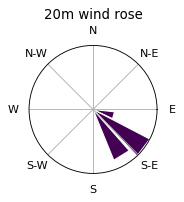

In [ ]:
from windrose import WindroseAxes
src = tidy_df[tidy_df.time.isin(upvalley_wind_times)][
    tidy_df.variable.isin(['spd_20m_c', 'dir_20m_c'])
].pivot_table(values = 'value', index='time', columns=['measurement']).reset_index()
ax = WindroseAxes.from_ax(figsize=(2,2))
ax.bar(src['wind direction'], src['wind speed'], normed=True, opening=.9, edgecolor='white', bins=1, nsector=17)
ax.set_yticks([])
# ax.set_yticklabels(['10%','25%'])
plt.title("20m wind rose")

In [ ]:
(alt.Chart().transform_calculate(y = '0').mark_rule().encode(y='y:Q') + alt.Chart(
    tidy_df[tidy_df.measurement == 'w'][tidy_df.time.isin(upvalley_nobs_times)]
).mark_line().encode(
    alt.X('hours(time):T').axis(labelAlign='center', values=[0,6,12,18,]),
    alt.Y('mean(value):Q').title('Vertical velocity (m/s)'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.StrokeDash('tower:N')
)) | (alt.Chart().transform_calculate(y = '0').mark_rule().encode(y='y:Q') + alt.Chart(
    tidy_df[tidy_df.measurement == 'w'][tidy_df.time.isin(downvalley_nobs_times)]
).mark_line().encode(
    alt.X('hours(time):T').axis(labelAlign='center', values=[0,6,12,18,]),
    alt.Y('mean(value):Q').title('Vertical velocity (m/s)'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.StrokeDash('tower:N')
))

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_86650/2828502726.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[tidy_df.measurement == 'w'][tidy_df.time.isin(upvalley_nobs_times)]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_86650/2828502726.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[tidy_df.measurement == 'w'][tidy_df.time.isin(downvalley_nobs_times)]


alt.HConcatChart(...)

## Analyze seasonal advection corrections

### Using 3-10m and 3-20m estimates

Text(0, 0.5, 'Cumulative sublimation (mm)')

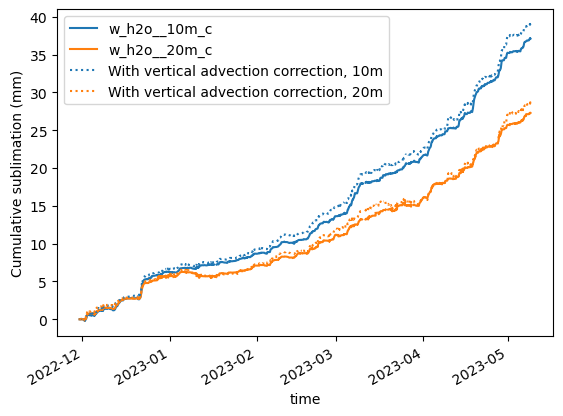

In [ ]:
# ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__3m_c).cumsum().plot()
w_h2o__10m_c_cumsum = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__10m_c).cumsum()
w_h2o__20m_c_cumsum = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__20m_c).cumsum()

w_h2o__10m_c_corrected_cumsum = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__10m_c
        + (
            10*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].vertical_advection_simple_3to10
        )
    )
).cumsum()
w_h2o__20m_c_corrected_cumsum = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__20m_c
        + (
            20*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].vertical_advection_simple_3to20
        )
    )
).cumsum()

w_h2o__10m_c_cumsum.plot(           color = 'tab:blue',     linestyle = '-')
w_h2o__20m_c_cumsum.plot(           color = 'tab:orange',   linestyle = '-')
w_h2o__10m_c_corrected_cumsum.plot( color = 'tab:blue',     linestyle = 'dotted',   label='With vertical advection correction, 10m')
w_h2o__20m_c_corrected_cumsum.plot( color = 'tab:orange',   linestyle = 'dotted',   label='With vertical advection correction, 20m')

plt.legend()
plt.ylabel('Cumulative sublimation (mm)')

In [ ]:
print('10m, ec\t\t', round(w_h2o__10m_c_cumsum.iloc[-1], 1))
print('10m, corrected\t', round(w_h2o__10m_c_corrected_cumsum.iloc[-1], 1))
print('20m, ec\t\t', round(w_h2o__20m_c_cumsum.iloc[-1], 1))
print('20m, corrected\t', round(w_h2o__20m_c_corrected_cumsum.iloc[-1], 1))

10m, ec		 37.1
10m, corrected	 39.0
20m, ec		 27.3
20m, corrected	 28.6


Text(0, 0.5, 'Cumulative sublimation (mm)')

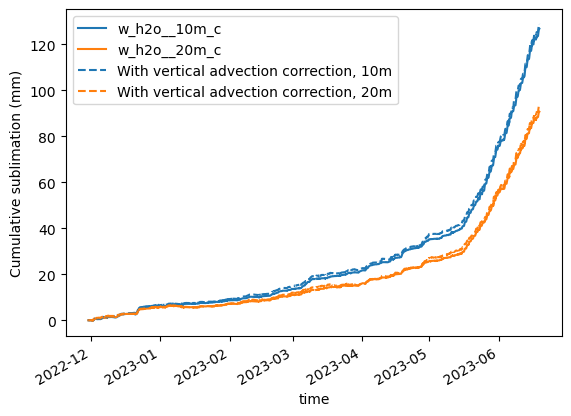

In [ ]:
# ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__3m_c).cumsum().plot()
w_h2o__10m_c_cumsum = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c).cumsum()
w_h2o__20m_c_cumsum = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__20m_c).cumsum()

w_h2o__10m_c_corrected_cumsum = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c
        + (
            10*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].vertical_advection_simple_3to10
        )
    )
).cumsum()
w_h2o__20m_c_corrected_cumsum = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__20m_c
        + (
            20*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].vertical_advection_simple_3to20
        )
    )
).cumsum()

w_h2o__10m_c_cumsum.plot(           color = 'tab:blue',     linestyle = '-')
w_h2o__20m_c_cumsum.plot(           color = 'tab:orange',   linestyle = '-')
w_h2o__10m_c_corrected_cumsum.plot( color = 'tab:blue',     linestyle = '--',   label='With vertical advection correction, 10m')
w_h2o__20m_c_corrected_cumsum.plot( color = 'tab:orange',   linestyle = '--',   label='With vertical advection correction, 20m')

plt.legend()
plt.ylabel('Cumulative sublimation (mm)')

In [ ]:
print('10m, ec\t\t', round(w_h2o__10m_c_cumsum.iloc[-1], 1))
print('10m, corrected\t', round(w_h2o__10m_c_corrected_cumsum.iloc[-1], 1))
print('20m, ec\t\t', round(w_h2o__20m_c_cumsum.iloc[-1], 1))
print('20m, corrected\t', round(w_h2o__20m_c_corrected_cumsum.iloc[-1], 1))

10m, ec		 126.9
10m, corrected	 128.8
20m, ec		 90.8
20m, corrected	 93.5


Text(0, 0.5, 'Cumulative sublimation (mm)')

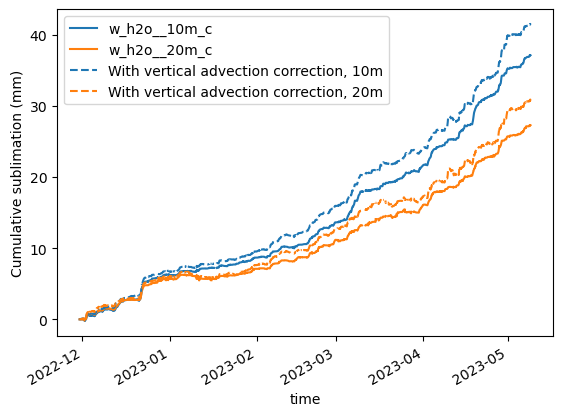

In [ ]:
# ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__3m_c).cumsum().plot()
w_h2o__10m_c_cumsum = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__10m_c).cumsum()
w_h2o__20m_c_cumsum = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__20m_c).cumsum()

w_h2o__10m_c_corrected_cumsum = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__10m_c
        + (
            10*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].vertical_advection_simple_2to10
        )
    )
).cumsum()
w_h2o__20m_c_corrected_cumsum = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__20m_c
        + (
            20*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].vertical_advection_simple_2to20
        )
    )
).cumsum()

w_h2o__10m_c_cumsum.plot(           color = 'tab:blue',     linestyle = '-')
w_h2o__20m_c_cumsum.plot(           color = 'tab:orange',   linestyle = '-')
w_h2o__10m_c_corrected_cumsum.plot( color = 'tab:blue',     linestyle = '--',   label='With vertical advection correction, 10m')
w_h2o__20m_c_corrected_cumsum.plot( color = 'tab:orange',   linestyle = '--',   label='With vertical advection correction, 20m')

plt.legend()
plt.ylabel('Cumulative sublimation (mm)')

In [ ]:
print('10m, ec\t\t', round(w_h2o__10m_c_cumsum.iloc[-1], 1))
print('10m, corrected\t', round(w_h2o__10m_c_corrected_cumsum.iloc[-1], 1))
print('20m, ec\t\t', round(w_h2o__20m_c_cumsum.iloc[-1], 1))
print('20m, corrected\t', round(w_h2o__20m_c_corrected_cumsum.iloc[-1], 1))

10m, ec		 37.1
10m, corrected	 41.5
20m, ec		 27.3
20m, corrected	 30.8


In [ ]:
daily_diffs_10m = []
daily_diffs_20m = []
for date in pd.Series(w_h2o__10m_c_cumsum.index.date).unique():
    daily_sub_corrected_10m = w_h2o__10m_c_corrected_cumsum.loc[
        date: date+dt.timedelta(days=1)][-1] - w_h2o__10m_c_corrected_cumsum.loc[date: date+dt.timedelta(days=1)][0]
    daily_sub_10m = w_h2o__10m_c_cumsum.loc[
        date: date+dt.timedelta(days=1)][-1] - w_h2o__10m_c_cumsum.loc[date: date+dt.timedelta(days=1)][0]
    daily_sub_corrected_20m = w_h2o__20m_c_corrected_cumsum.loc[
        date: date+dt.timedelta(days=1)][-1] - w_h2o__20m_c_corrected_cumsum.loc[date: date+dt.timedelta(days=1)][0]
    daily_sub_20m = w_h2o__20m_c_cumsum.loc[
        date: date+dt.timedelta(days=1)][-1] - w_h2o__20m_c_cumsum.loc[date: date+dt.timedelta(days=1)][0]
    daily_diffs_10m.append(
        (daily_sub_corrected_10m - daily_sub_10m) / daily_sub_10m
    )
    daily_diffs_20m.append(
        (daily_sub_corrected_20m - daily_sub_20m) / daily_sub_20m
    )
daily_diffs_df = pd.DataFrame({
    'date' : pd.Series(w_h2o__10m_c_cumsum.index.date).unique(),
    'daily_diffs_10m' : daily_diffs_10m,
    'daily_diffs_20m' : daily_diffs_20m
})

<Axes: xlabel='time'>

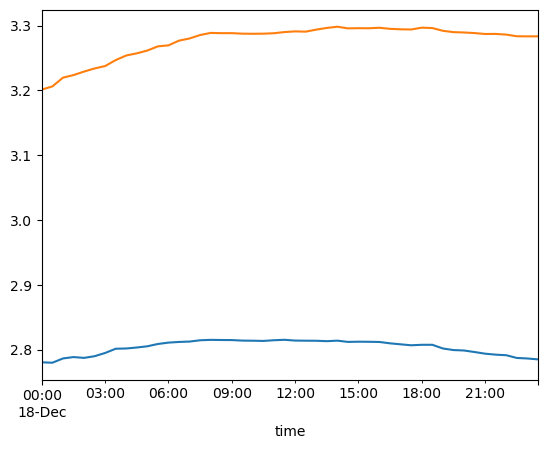

In [ ]:
w_h2o__10m_c_cumsum.loc['2022-12-18'].plot()
w_h2o__10m_c_corrected_cumsum.loc['2022-12-18'].plot()

In [ ]:
daily_diffs_df.sort_values('daily_diffs_10m', ascending=False).head(20)

,date,daily_diffs_10m,daily_diffs_20m
18,2022-12-18,102.619494,-2.405295
0,2022-11-30,35.831941,-30.278930
132,2023-04-11,8.321354,19.761452
154,2023-05-03,8.018923,-3.483246
17,2022-12-17,5.674685,-3.002620
72,2023-02-10,3.925583,NaN
78,2023-02-16,3.574755,NaN
19,2022-12-19,3.070171,1.829549
87,2023-02-25,2.533971,4.819698
130,2023-04-09,2.503451,3.951766


In [ ]:
print(daily_diffs_df.dropna().daily_diffs_10m.mean())

1.0977912191218715


In [ ]:
print(daily_diffs_df.dropna().daily_diffs_10m.median())

0.0717914093946824


In [ ]:
print(daily_diffs_df.dropna().daily_diffs_10m.quantile(0))
print(daily_diffs_df.dropna().daily_diffs_10m.quantile(.25))
print(daily_diffs_df.dropna().daily_diffs_10m.quantile(.50))
print(daily_diffs_df.dropna().daily_diffs_10m.quantile(.75))
print(daily_diffs_df.dropna().daily_diffs_10m.quantile(1.0))

-24.356574325233193
-0.24062332474885892
0.0717914093946824
0.5225361435904954
102.61949355444548


array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

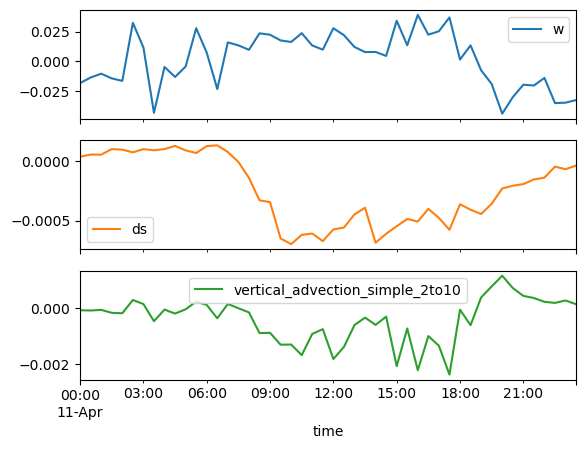

In [ ]:
kps_vert_simple_df_2to10.loc['2023-04-11'][[
    'w','ds','vertical_advection_simple_2to10'
]].plot(subplots=True)

In [ ]:
alt.Chart(daily_diffs_df).mark_bar().encode(
    alt.X('daily_diffs_10m:Q').bin(
        extent=[-25, 125], step=5
    ).axis(
        values=[-25, 0, 25, 50, 75, 100, 125]
    ).title('% change in daily sublimation w/ advection correction'),
    alt.Y('count():Q').scale(type='symlog').axis(values=[0,1,2,10,20,50,100])
)

alt.Chart(...)

In [ ]:
alt.Chart(daily_diffs_df).mark_bar().encode(
    alt.X('daily_diffs_20m:Q').bin(
        extent=[-25, 125], step=5
    ).axis(
        values=[-25, 0, 25, 50, 75, 100, 125]
    ).title('% change in daily sublimation w/ advection correction'),
    alt.Y('count():Q').scale(type='symlog').axis(values=[0,1,2,10,20,50,100])
)

alt.Chart(...)

In [ ]:
ec_3m = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__3m_c)
ec_5m = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__5m_c)
ec_10m = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__10m_c)
ec_20m = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__20m_c)

ec_advection_corrected_10m = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__10m_c
        + (
            10*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].vertical_advection_simple_3to10
        )
    )
)
ec_advection_corrected_20m = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].w_h2o__20m_c
        + (
            20*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508'].vertical_advection_simple_3to20
        )
    )
)

cumsub_df = pd.DataFrame({
    'EC (3m)' : ec_3m,
    'EC (5m)' : ec_5m,
    'EC (10m)' : ec_10m,
    'EC (20m)' : ec_20m,
    'EC w/ advection correction (10m)' : ec_advection_corrected_10m,
    'EC w/ advection correction (20m)' : ec_advection_corrected_20m,
})
# calculate a combined 3m/10m estimate, selecting height based on blowing snow
cumsub_df['EC (3 and 10m)'] = cumsub_df.apply(
    lambda row: row['EC (10m)'] if row.name in bs_times else row['EC (3m)'],
    axis=1
)
cumsub_df = cumsub_df.cumsum()

In [ ]:
domain = [
        'EC (3m)', 
        'EC (5m)', 
        'EC (10m)', 
        'EC w/ advection correction (10m)',
        'EC (20m)', 
        'EC w/ advection correction (20m)',
        'EC (3 and 10m)',
    ]
color_range = ['#1f77b4', '#ff7f0e', '#2ca02c', '#2ca02c', '#d62728', '#d62728', '#9467bd']
dash_range = [[1,0], [1,0], [1,0], [4,2], [1,0], [4,2], [1,0]]
alt.Chart(cumsub_df.reset_index()).transform_fold(
    domain
).transform_window(
    rolling_avg = 'mean(value)',
    groupby=['key'],
    frame =[-6,6]
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('rolling_avg:Q').title('Cumulative sublimation (mm SWE)').scale(
        domain = [0,45]
    ),
    alt.Color('key:N').title('Sublimation estimate').scale(domain=domain, range=color_range),
    alt.StrokeDash('key:N').scale(domain=domain, range=dash_range)
).properties(width=300, height=300).display(renderer='svg')

alt.Chart(...)

In [ ]:
alt.Chart(cumsub_df.reset_index()).transform_fold(
    domain
).mark_bar().encode(
    alt.Y('key:N').title('Sublimation estimate').sort(domain),
    alt.X('max(value):Q').title('Seasonal sublimation (mm SWE)'),
).properties(width=300, height=300).display(renderer='svg')

alt.Chart(...)

In [ ]:
cumsub_df.max()

EC (3m)                             33.766463
EC (5m)                             35.926747
EC (10m)                            37.141965
EC (20m)                            27.308988
EC w/ advection correction (10m)    39.042193
EC w/ advection correction (20m)    28.688265
EC (3 and 10m)                      38.378562
dtype: float64

## Analyze case studies

### December case study

In [ ]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20221221 1200': '20221223 0000'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to10',
        'vertical_advection_simple_3to10_uncertainty',
        'vertical_turb_flux_divergence_3to10',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt',
        'lateral_advection_3m_uncertainty',
        'vertical_advection_simple_3to20',
        'vertical_advection_simple_3to20_uncertainty',
    ]].reset_index()


src['vertical_advection_lb'] = src['vertical_advection_simple_3to10'] - src['vertical_advection_simple_3to10_uncertainty']
src['vertical_advection_ub'] = src['vertical_advection_simple_3to10'] + src['vertical_advection_simple_3to10_uncertainty']

lines_chart = alt.Chart(src).transform_fold([
    'vertical_advection_simple_3to10',
    # 'vertical_advection_simple_3to20',
    'vertical_turb_flux_divergence_3to10',
    # 'vertical_turb_flux_divergence_3to20',
    # 'ds/dt'
]).mark_line().encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Water vapor flux density', '(g/m^3/s)']).scale(
        domain = [-0.002, 0.005], clamp=True
    ),
    alt.Color('key:N', )
).properties(width=250, height = 166.66) 

vert_adv_uncert_chart = alt.Chart(src).mark_area(
    color = '#1f77b4',
    opacity=0.35
).encode(
    alt.X('time:T'),
    alt.Y('vertical_advection_lb:Q').title(''),
    alt.Y2('vertical_advection_ub:Q').title(''),
)    

bs_chart = alt.Chart(
    tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20221221 1200': '20221223 0000'].reset_index()
).mark_line(color='black').encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
    alt.StrokeDash('height:N', legend=None)
)

w_q_chart = alt.Chart(
    tidy_df[tidy_df.variable.isin(
        [
            'w_h2o__2m_c_raw', 'w_h2o__3m_c_raw', 
            'w_h2o__5m_c_raw', 
            'w_h2o__10m_c_raw', 'w_h2o__15m_c_raw','w_h2o__20m_c_raw'])
    ].set_index('time').loc['20221221 1200': '20221223 0000'].reset_index()
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-1,1],
    groupby = ['height']
).mark_line().encode(
    alt.X('time:T'). axis().title(None),
    alt.Y('rolling_avg:Q').title(["w'q' (g/m^2/s)"]),
    alt.Color('height:O').scale(scheme='turbo')
)


(
    bs_chart.properties(width=250, height = 83.33)
    &
    w_q_chart.properties(width=250, height = 83.33)
    &
    (vert_adv_uncert_chart + lines_chart)
).resolve_scale(
    x='shared', color='independent', strokeDash='independent'
).display(renderer='svg')

alt.VConcatChart(...)

### February case study

In [ ]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20230211': '20230212'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection_3m',
        'ds/dt'
    ]].reset_index()

feb_casestudy_differential_form = (
    alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection_3m',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N', )
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230211': '20230212'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', legend=None)
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

feb_casestudy_differential_form

alt.VConcatChart(...)

### April/May case studies

In [ ]:
def get_nice_advection_timeseries(date, date2=None, frame=[-2,2], width=300, height = 200, ydomain=[-0.001,0.001]):
    if date2 is None:
        date2 = date
    src = advection_1d_fluxdensity_nonnorm_df.loc[date: date2][[
            'w_h2o__3m_c',
            'w_h2o__20m_c',
            'vertical_advection_simple_3to10',
            'vertical_advection_simple_3to20',
            'vertical_advection_simple_3to20_uncertainty',
            'vertical_turb_flux_divergence_3to20',
            'lateral_advection_3m',
            'lateral_advection_3m_uncertainty',
            'ds/dt'
        ]].reset_index()

    src['vertical_advection_lb'] = src['vertical_advection_simple_3to20'] - src['vertical_advection_simple_3to20_uncertainty']
    src['vertical_advection_ub'] = src['vertical_advection_simple_3to20'] + src['vertical_advection_simple_3to20_uncertainty']
    src['lateral_advection_lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']
    src['lateral_advection_ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']

    flux_div_chart = alt.Chart(src).transform_fold([
        # 'vertical_advection_simple_3to10',
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        # 'lateral_advection_3m',
        # 'ds/dt'
    ]).transform_window(
        rolling_avg = 'mean(value)',
        frame=frame,
        groupby = ['key']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['Water vapor flux density', '(g/m^2/s)']).scale(domain=ydomain, clamp=True),
        alt.Color('key:N')
    ).properties(width=width, height = height)

    vert_adv_errorbar = alt.Chart(src).transform_window(
        rollavg_vert_adv_lb = 'mean(vertical_advection_lb)',
        rollavg_vert_adv_ub = 'mean(vertical_advection_ub)',
        frame=frame,
        groupby = ['key']
    ).mark_area(
        opacity = 0.3,
        color = '#1f77b4'
    ).encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rollavg_vert_adv_lb:Q').title(''),
        alt.Y2('rollavg_vert_adv_ub:Q').title(''),
    )


    return  vert_adv_errorbar + flux_div_chart

In [ ]:
def get_chart(date):
    flux_div_chart = get_nice_advection_timeseries(date).properties(
        width=300, height = 125
    )

    w_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c','w_20m_c'])
        ].set_index('time').sort_index().loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['Vertical wind speed (m/s)']),
        # alt.Y('value:Q').title(['Vertical wind speed (m/s)']),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    dir_chart = alt.Chart(
        tidy_df[
            tidy_df.variable == 'dir_20m_c'
        ].set_index('time').loc[date: date].reset_index()
    ).mark_line(color='black', strokeDash=[4,2]).encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('value:Q').title(['Wind direction']),
    ).properties(width=300, height = 125)

    mixingratio_chart = alt.Chart(
        tidy_df.query("measurement == 'mixing ratio'").set_index('time').loc[date: date].reset_index()
    ).transform_filter(
        'hours(datum.time)%3 == 0 & hours(datum.time)%6 != 0'
    ).transform_calculate(
        value_g_per_kg = '1000 * datum.value'
    ).mark_line().encode(
        alt.X('mean(value_g_per_kg):Q').sort('-y').title('s (g/kg)').scale(zero=True),
        alt.Y('height:Q'),
        alt.Facet('hours(time):O', spacing=5),
    ).properties(width=70, height = 70)

    # wspd_chart = alt.Chart(
    #     tidy_df.query("measurement == 'wind speed'").query("tower == 'c'").set_index('time').loc[date: date].reset_index()
    # ).transform_filter(
    #     # 'hours(datum.time)%3 == 0 & hours(datum.time)%6 != 0'
    #     'hours(datum.time)%1 == 0'
    # ).mark_point().encode(
    #     alt.X('mean(value):Q').sort('-y'),
    #     alt.Y('height:Q'),
    #     alt.Facet('hours(time):O', spacing=5),
    # ).properties(width=70, height = 70)

    lhflux_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['w_h2o__3m_c_raw', 
             'w_h2o__5m_c_raw', 
             'w_h2o__10m_c_raw', 'w_h2o__15m_c_raw','w_h2o__20m_c_raw'])
        ].set_index('time').loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-1,1],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(["w'q' (g/m^2/s)"]),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    ri_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['Ri_3m_c', 'Ri_20m_c'])
        ].set_index('time').loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'median(value)',
        frame=[-1,1],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['Ri']).scale(domain=[-1,2], clamp=True),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    T_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['Tsurf_c', 'T_3m_c', 'T_20m_c'])
        ].set_index('time').loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'median(value)',
        frame=[-1,1],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['T (˚C)']),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    wspd_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['spd_3m_c', 'spd_20m_c'])
        ].set_index('time').loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'median(value)',
        frame=[-1,1],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['Wind speed (m/s)']),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    return (
        lhflux_chart 
        & (w_chart + dir_chart).resolve_scale(y='independent') 
        & flux_div_chart 
        # & ri_chart & mixingratio_chart 
        # & wspd_chart 
        # & T_chart
    ).resolve_scale(color='independent')

In [ ]:
get_chart('20230505')

alt.VConcatChart(...)

In [ ]:
(get_chart('20230415') | get_chart('20230417') ).display(renderer='svg')

alt.HConcatChart(...)

In [ ]:
(get_chart('20230415') | get_chart('20230607') ).display(renderer='svg')

alt.HConcatChart(...)

In [ ]:
(get_chart('20230415') | get_chart('20230418') ).display(renderer='svg')

alt.HConcatChart(...)

In [ ]:
rule = alt.Chart().transform_calculate(y='0').mark_rule().encode(y='y:Q')
local_downvalley_wind_times = tidy_df[
    tidy_df.variable == 'dir_3m_c'
].dropna().query("value < 360").query("value > 252").drop_duplicates().time
# src = src[src.time.isin(local_downvalley_wind_times)]
vars = [
        'w_2m_c', 'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
        'w_3m_d', 'w_10m_d',
        'w_3m_ue', 'w_10m_ue',
        'w_3m_uw', 'w_10m_uw',
    ]
(alt.Chart(
    tidy_df[tidy_df.variable.isin(
        ['dir_3m_c'] + vars
    )].pivot(index='time', columns='variable', values='value')
).transform_fold(vars).mark_boxplot(outliers=False).encode(
    alt.X('dir_3m_c:Q').bin(maxbins=20),
    alt.Y('value:Q').scale(domain=[-0.5, 0.5], clamp=True).title('Vertical wind speed (m/s)'),
    alt.Facet('key:O', columns = 3).sort(vars)
)).properties(height = 200, width=300)

alt.Chart(...)

In [ ]:
rule = alt.Chart().transform_calculate(y='0').mark_rule().encode(y='y:Q')
local_downvalley_wind_times = tidy_df[
    tidy_df.variable == 'dir_3m_c'
].dropna().query("value < 360").query("value > 252").drop_duplicates().time
# src = src[src.time.isin(local_downvalley_wind_times)]
vars = [
        'w_10m_c',
        'w_10m_d',
         'w_10m_ue',
         'w_10m_uw',
    ]
(alt.Chart(
    tidy_df[tidy_df.variable.isin(
        ['dir_3m_c'] + vars
    )].pivot(index='time', columns='variable', values='value')
).transform_fold(vars).mark_boxplot(outliers=False).encode(
    alt.X('dir_3m_c:Q').bin(maxbins=20),
    alt.Y('value:Q').scale(domain=[-0.5, 0.5], clamp=True).title('Vertical wind speed (m/s)'),
    alt.Facet('key:O', columns = 2).sort(vars)
)).properties(height = 200, width=300)

alt.Chart(...)

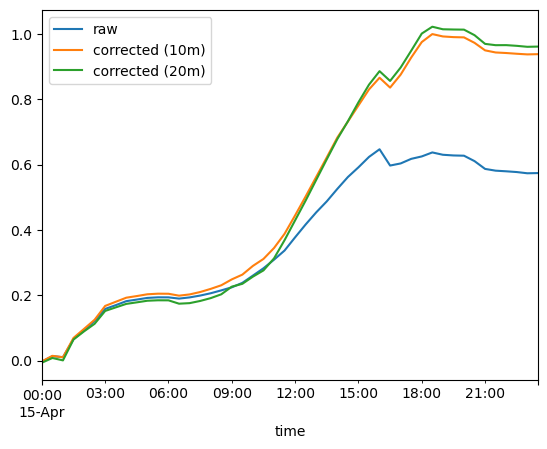

In [ ]:
raw = (
    (1800/1000)*(advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c)
)
corrected_10m = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c
        + (
            10*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].vertical_advection_simple_3to10
        )
    )
)
corrected_20m = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c
        + (
            20*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].vertical_advection_simple_3to20
        )
    )
)
raw.loc['20230415': '20230415'].cumsum().plot(label = 'raw')
corrected_10m.loc['20230415': '20230415'].cumsum().plot(label = 'corrected (10m)')
corrected_20m.loc['20230415': '20230415'].cumsum().plot(label = 'corrected (20m)')
plt.legend()

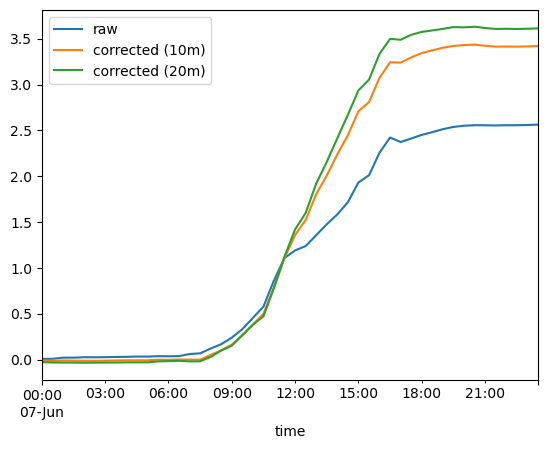

In [ ]:
raw = (
    (1800/1000)*(advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c)
)
corrected_10m = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c
        + (
            10*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].vertical_advection_simple_3to10
        )
    )
)
corrected_20m = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c
        + (
            20*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].vertical_advection_simple_3to20
        )
    )
)
raw.loc['20230607': '20230607'].cumsum().plot(label = 'raw')
corrected_10m.loc['20230607': '20230607'].cumsum().plot(label = 'corrected (10m)')
corrected_20m.loc['20230607': '20230607'].cumsum().plot(label = 'corrected (20m)')
plt.legend()

In [ ]:
measurements = [
    'w_h2o_',   'u_h2o_',   'v_h2o_', 
    'w_tc_',    'u_tc_',    'v_tc_',   
    'u_w_', 'v_w_', 
    'turbulent kinetic energy',
    'mixing ratio',
    'potential temperature',
    'w',
]
heights = [3, 5, 10, 15, 20]
date = '20230417'
src = tidy_df[tidy_df.measurement.isin(measurements)]
src = src[ ~ src.variable.str.contains('predicted')]
src = src.set_index('time').loc[date: date].reset_index()
src = src.query("tower == 'c'")
src = src[src.height.isin(heights)]

alt.Chart(src).mark_line().encode(
    alt.X('time:T'). axis().title(None),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.Facet("measurement:N", columns = 3).sort(
        measurements
    )
).properties(width=300, height = 125).resolve_scale(
    y='independent'
)

alt.Chart(...)

In [ ]:
kps_mixingratio_vars = [
    'Tsurfmixingratio_c',
    'mixingratio_1m_c',
    'mixingratio_2m_c',
    'mixingratio_3m_c',
    'mixingratio_4m_c',
    'mixingratio_5m_c',
    'mixingratio_6m_c',
    'mixingratio_7m_c',
    'mixingratio_8m_c',
    'mixingratio_9m_c'
    'mixingratio_10m_c',
    'mixingratio_11m_c',
    'mixingratio_12m_c',
    'mixingratio_13m_c',
    'mixingratio_14m_c',
    'mixingratio_15m_c',
    'mixingratio_16m_c',
    'mixingratio_17m_c',
    'mixingratio_18m_c',
    'mixingratio_19m_c',
    'mixingratio_20m_c',
]
s_compare_df = tidy_df[tidy_df.variable.isin(kps_mixingratio_vars)].set_index('time').loc['20230505':'20230505'][['value', 'height']]
s_compare_df['site'] = 'kps'
s_compare_df_annex = s_annex_df.sort_index().loc['20230505':'20230505'].rename(columns={'mixing_ratio_annex': 'value'})
s_compare_df_annex = s_compare_df_annex.resample('30min').mean()
s_compare_df_annex['height'] = 2.8
s_compare_df_annex['site'] = 'annex'
s_compare_df = pd.concat([s_compare_df.reset_index(), s_compare_df_annex.reset_index()])
s_compare_df['value'] = s_compare_df['value']*1000
alt.Chart(s_compare_df).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=False).title('mixing ratio (g/kg)'),
    alt.Color('height:N').scale(
        domain = [2.8, 2, 3, 4],
        range = ['black', '#1f77b4', '#ff7f0e', '#2ca02c']
    )
).properties(width=400, height=200)

alt.Chart(...)

In [ ]:
(alt.Chart(
    tidy_df.query("measurement == 'wind speed'").set_index('time').loc['20230415'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.StrokeDash('tower:N')
) & alt.Chart(
    tidy_df.query("measurement == 'temperature'").set_index('time').loc['20230415'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.StrokeDash('tower:N')
)).resolve_scale(color='independent', strokeDash='independent')

alt.VConcatChart(...)

In [ ]:
(alt.Chart(
    tidy_df.query("measurement == 'wind speed'").set_index('time').loc['20230417'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.StrokeDash('tower:N')
) & alt.Chart(
    tidy_df.query("measurement == 'temperature'").set_index('time').loc['20230417'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.StrokeDash('tower:N')
)).resolve_scale(color='independent', strokeDash='independent')

alt.VConcatChart(...)

<Axes: xlabel='time'>

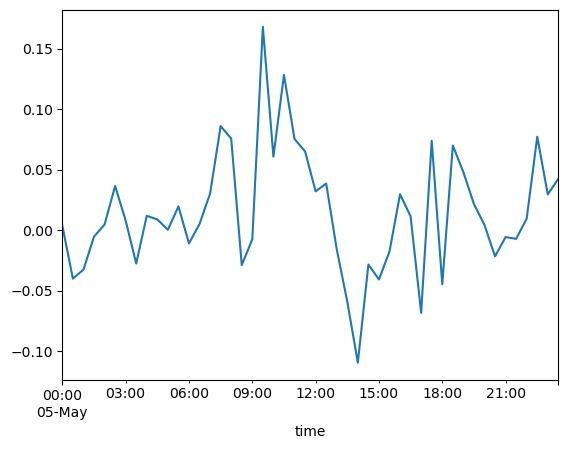

In [ ]:
s_compare_df['site_and_height'] = s_compare_df['site'] + '_' + s_compare_df['height'].astype('str')
s_compare_df = s_compare_df.pivot(index='time', values='value', columns='site_and_height')
(s_compare_df['kps_3.0'] - s_compare_df['annex_2.8']).plot()

In [ ]:
(s_compare_df['kps_3.0'] - s_compare_df['annex_2.8']).mean(), (s_compare_df['kps_3.0'] - s_compare_df['annex_2.8']).max(), (s_compare_df['kps_3.0'] - s_compare_df['annex_2.8']).min()

(0.014726765214140717, 0.1683665935216041, -0.10966509517511724)

<Axes: xlabel='time'>

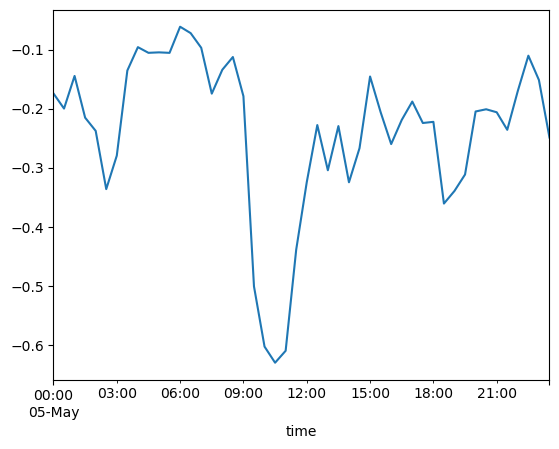

In [ ]:
(s_compare_df['kps_20.0'] - s_compare_df['kps_3.0']).plot()

In [ ]:
(s_compare_df['kps_20.0'] - s_compare_df['kps_3.0']).mean(),(s_compare_df['kps_20.0'] - s_compare_df['kps_3.0']).max(),(s_compare_df['kps_20.0'] - s_compare_df['kps_3.0']).min(),

(-0.23782626036942625, -0.061050523072481155, -0.6296669598668814)

In [ ]:
src = s_compare_df.query("height <= 20").query("height > 0")
alt.Chart(src).transform_filter(
    'hours(datum.time) % 3 == 0 & hours(datum.time) >= 6 & hours(datum.time) <= 18'
).mark_line(point=True).encode(
    alt.X('mean(value):Q').scale(zero=False).title(['mixing ratio', '(g/kg)']).axis(values=[2,3,4]),
    alt.Y('height').title('height (m)'),
    alt.Color('site:N', sort='descending').scale(
        domain = ['kps', 'annex'],
        range = ['#ff7f0e', 'black', ],
    ),
    alt.Order('height'),
    alt.Facet('hours(time):T', columns=5, spacing=2).header(format='%H:%M')
).properties(width=75, height=100).resolve_scale(x='shared').display(renderer='svg')

UndefinedVariableError: name 'height' is not defined

In [ ]:
alt.Chart(
    tidy_df[tidy_df.variable == 'spd_3m_c'].set_index('time').loc['20230505':'20230505'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('Horizontal wind speed (m/s)')
).properties(width=400, height=200)

In [ ]:
alt.Chart(
    tidy_df[tidy_df.measurement == 'w_h2o_'].query("tower == 'c'").set_index('time').loc['20230505 1000 ': '20230505 1700'].reset_index()
).mark_line().encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('minutes(time):N'),
    alt.Facet('hours(time)', columns=8)
).properties(height = 100, width= 100) &\
alt.Chart(
    tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").set_index('time').loc['20230505 1000 ': '20230505 1700'].reset_index()
).mark_line().encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('minutes(time):N'),
    alt.Facet('hours(time)', columns=8)
).properties(height = 100, width= 100) &\
alt.Chart(
    tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'").set_index('time').loc['20230505 1000 ': '20230505 1700'].reset_index()
).mark_line().encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('minutes(time):N'),
    alt.Facet('hours(time)', columns=8)
).properties(height = 100, width= 100)

In [ ]:

src = tidy_df[tidy_df.measurement == 'wind direction'][tidy_df.height.isin([3,10,20])]
src = src.set_index('time').loc['20230501':'20230508'].reset_index()
alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.StrokeDash('height:O')
).properties(width=1000)

In [ ]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20230415': '20230420'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt'
    ]].reset_index()

april_casestudy_differential_form = (
    alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt'
    ]).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby = ['key']
    ).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('rolling_avg:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N')
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230415': '20230420'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', )
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

april_casestudy_differential_form

### Mid-May Case Study, lateral advection due to source heterogeneity

In [ ]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20230510': '20230520'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt'
    ]].reset_index()

may_casestudy_differential_form = (
    alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt'
    ]).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby = ['key']
    ).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('rolling_avg:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N')
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230510': '20230520'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', )
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

may_casestudy_differential_form

# Data exploration

## Compare IRGA and Hygrometer measurements

In [ ]:
comparison_df = pd.concat([
    (1000*tidy_df[tidy_df.measurement=='specific humidity'].set_index(['time','height','tower', 'measurement'])),
    tidy_df[tidy_df.measurement=='air density'].set_index(['time','height','tower', 'measurement']),
    tidy_df[tidy_df.measurement=='Water vapor density'].set_index(['time','height','tower', 'measurement'])
])[['value']]
comparison_df = comparison_df.reset_index().pivot_table(values='value', columns='measurement', index=['time','height','tower'])
comparison_df ['Water vapor density (hygr)'] = comparison_df['air density'] * comparison_df['specific humidity']
comparison_df = comparison_df.rename(columns={'Water vapor density': 'Water vapor density (irga)'})
comparison_df

In [ ]:


src = comparison_df.loc[:,3,'c'].reset_index()
# max_val = math.ceil(
#     src[['Water vapor density (hygr)', 'Water vapor density (irga)']].dropna().values.max()
# )
max_val = 7
line = pd.DataFrame({
    'Goals Conceded': [0, max_val],
    'Goals': [0, max_val],
})

arr = np.array([0, max_val] * (len(src) // 2))
if len(arr) < len(src):
    src['one'] = list(arr) + [0]
    src['onetoone'] = list(arr) + [0]
else:
    src['one'] = list(arr)
    src['onetoone'] = list(arr)

line_plot = alt.Chart().mark_line(color= 'grey').encode(
    alt.X('one', title=''),
    alt.Y('onetoone', title='')
)
scatter_plot = alt.Chart().mark_rect().encode(
    alt.X('Water vapor density (hygr):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (hygr)'),
    alt.Y('Water vapor density (irga):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (irga)'),
    alt.Color('count()'),
).properties(width=200, height=200)

src['diff'] = (src.set_index('time')['Water vapor density (irga)'] - src.set_index('time')['Water vapor density (hygr)']).values


meanerror_by_month = round(src.groupby(src.time.dt.month).mean().drop(columns='time')['diff'], 3)
r2_by_month = round(src.groupby(src.time.dt.month)[[
    'Water vapor density (hygr)', 'Water vapor density (irga)'
]].apply(
    lambda df: r2_score(df.dropna()['Water vapor density (hygr)'], df.dropna()['Water vapor density (irga)'])
), 3)

def r2_plot(month, title):
    return alt.layer(
        scatter_plot,
        line_plot,
        data=src[(src.time.dt.month == month)]
    ).properties(title=f'{title} (ME: {meanerror_by_month.loc[month]}, R2: {r2_by_month.loc[month]})')

(
    r2_plot(11, 'Nov.') | r2_plot(12, 'Dec.') | r2_plot(1, 'Jan.') | r2_plot(2, 'Feb.') | r2_plot(3, 'Mar.') | r2_plot(4, 'Apr.') | r2_plot(5, 'May') 
) & (
    alt.layer(
        alt.Chart().mark_rule().transform_calculate(
            y = '0'
        ).mark_rule().encode(alt.Y('y:Q')),
        alt.Chart().mark_line().encode(
            alt.X('hoursminutes(time):T'),
            alt.Y('mean(diff):Q').title('Mean difference (irga - hygr) (g/m^3)'),
        ),
        data = src[(src.time.dt.month != 10)]
    ).properties(width=230, height=230).facet(
        column=alt.Column('month(time):T', sort=[11,12,1,2,3,4,5,6])
    )  
)

# DL vertical staring BL turbulence

In [ ]:
import act.discovery, act.io
# Inputs
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
start_date = "20230505"
end_date = "20230506"
DLW_DATA_STREAM = 'gucdlprofwstats4newsM1.c1'
DLW_DATA_STREAM_FILEEXT = '.cdf'
DLW_OUTPUT_DIR = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", DLW_DATA_STREAM)
file_list = act.discovery.download_arm_data(
            username, token, DLW_DATA_STREAM, start_date, end_date, output = DLW_OUTPUT_DIR)

In [ ]:
wstats_df = act.io.read_arm_netcdf(file_list).to_dataframe().reset_index()
wstats_df = utils.modify_df_timezone(wstats_df, 'UTC', 'US/Mountain')
wstats_df = wstats_df[(wstats_df.time > '20230505') & (wstats_df.time < '20230506')]
wstats_df['time_low'] = wstats_df['time'] - dt.timedelta(minutes=5)
wstats_df['time_high'] = wstats_df['time'] + dt.timedelta(minutes=5)
wstats_df['height_low'] = wstats_df['height'] - 15
wstats_df['height_high'] = wstats_df['height'] + 15
wstats_df = wstats_df.rename(columns={'w_variance': 'value'})

In [ ]:
alt.Chart(
    wstats_df.set_index('time').query("height < 1000").reset_index()
).mark_bar().encode(
    alt.X('w:Q').title(["w", "(m/s)"]).bin(step=0.25).axis(values=[-4,-2,-1,0,1,2,4]),
    alt.Y('count():Q')
).properties(
    width=200, height = 200,
) | alt.Chart(
    wstats_df.set_index('time').query("height < 1000").reset_index()
).mark_rect().encode(
    alt.X('time_low:T').title('time'),
    alt.X2('time_high:T'),
    alt.Y('height_low:Q').title('Height (m)'),
    alt.Y2('height_high:Q'),
    alt.Color('w:Q').title(["w", "(m/s)"]).scale(scheme='purpleorange', domain=[-1,1],),
    tooltip='value'
).properties(
    width=500, height = 200,
    title = 'Vertical velocity from Doppler Lidar at Gothic'
)

In [ ]:
src = wstats_df.set_index('time').query("height < 1000")[['w', 'height']]
src = src.groupby([pd.Grouper(freq='30min'), 'height']).mean().reset_index()
src['time_low'] = src['time'] - dt.timedelta(minutes=15)
src['time_high'] = src['time'] + dt.timedelta(minutes=15)
src['height_low'] = src['height'] - 15
src['height_high'] = src['height'] + 15

alt.Chart(
    src
).mark_rect().encode(
    alt.X('time_low:T').title('time'),
    alt.X2('time_high:T'),
    alt.Y('height_low:Q').title('Height (m)'),
    alt.Y2('height_high:Q'),
    alt.Color('w:Q').title(["w", "(m/s)"]).scale(scheme='purpleorange', domain=[-1,1],),
).properties(
    width=500, height = 200,
    title = 'Vertical velocity from Doppler Lidar at Gothic'
) &\
alt.Chart(
    wstats_df.set_index('time').query("height < 500")[['w', 'height']].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('mean(w):Q')
).properties(width=500, height = 200)

In [ ]:
alt.Chart(wstats_df).mark_bar().encode(
    alt.X('value:Q').title(["w'w'", "(m² s⁻²)"]).bin(step=2),
    alt.Y('count():Q')
).properties(
    width=200, height = 200,
) | alt.Chart(
    wstats_df.set_index('time').query("height < 2000").reset_index()
).mark_rect().encode(
    alt.X('time_low:T').title('time'),
    alt.X2('time_high:T'),
    alt.Y('height_low:Q').title('Height (m)'),
    alt.Y2('height_high:Q'),
    alt.Color('value:Q').title(["w'w'", "(m² s⁻²)"]).scale(scheme='turbo'),
    tooltip='value'
).properties(
    width=500, height = 200,
    title = 'Vertical velocity variance from Doppler Lidar at Gothic'
)

In [ ]:
src = tidy_df[
        (tidy_df.time > '20230505') & (tidy_df.time < '20230506')
    ].query("measurement == 'w_w_'").query("tower == 'c'")
src['time_low'] = src['time'] - dt.timedelta(minutes=15)
src['time_high'] = src['time'] + dt.timedelta(minutes=15)
src['height_low'] = src['height'].apply(lambda h: {
    1: 0,
    2: 1,
    3: 2,
    5: 3,
    10: 6.25,
    15: 10.25,
    20: 14.5,
}.get(h))
src['height_high'] = src['height'].apply(lambda h: {
    1: 1,
    2: 2,
    3: 3,
    5: 6.25,
    10: 10.25,
    15: 14.5,
    20: 20,
}.get(h))

alt.Chart(src).mark_bar().encode(
    alt.X('value:Q').title(["w'w' (m² s⁻²)"]).bin(),
    alt.Y('count():Q')
).properties(
    width=200, height = 200,
) | alt.Chart(
    src
).mark_rect().encode(
    alt.X('time_low:T').title('time'),
    alt.X2('time_high:T'),
    alt.Y('height_low:Q').title('Height (m)'),
    alt.Y2('height_high:Q'),
    alt.Color('value:Q').title(["w'w'", "(m² s⁻²)"]).scale(scheme='turbo'),
    tooltip='value'
).properties(
    width=500, height = 200,
    title = "w'w' from Tower c"
)

In [ ]:
upper_chart = alt.Chart(
        wstats_df.set_index('time').query("height < 2000").query("height >= 20").reset_index()
    ).mark_rect().encode(
        alt.X('time_low:T').title('time').axis(None),
        alt.X2('time_high:T'),
        alt.Y('height_low:Q').title('Height (m)').scale(domain = [20, 2000]),
        alt.Y2('height_high:Q'),
        alt.Color('value:Q').title(["w'w'", "(m² s⁻²)"]).scale(scheme='turbo'),
        tooltip='value'
    ).properties(
        width=500, height = 200,
        title = 'Vertical velocity variance from Doppler Lidar at Gothic'
    )
lower_chart = alt.Chart(
        src
    ).mark_rect().encode(
        alt.X('time_low:T').title('time'),
        alt.X2('time_high:T'),
        alt.Y('height_low:Q').title('Height (m)'),
        alt.Y2('height_high:Q'),
        alt.Color('value:Q').title(["w'w'", "(m² s⁻²)"]).scale(domain=[0,8], scheme='turbo'),
        tooltip='value'
    ).properties(
        width=500, height = 100,
    )
alt.vconcat(
    upper_chart,
    lower_chart,
    spacing = -2
).resolve_scale(x='shared', color='shared')

In [ ]:
alt.Chart(src.loc['20230505']).mark_circle().encode(
    alt.X('value:Q'),
    alt.Y('height:Q')
).properties(width=250,height=150)